# Field Potential Analysis (Full)

In [214]:
from pathlib import Path, PurePath
import glob
import math
import ast
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyabf
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve, butter, sosfiltfilt, bessel, savgol_filter, argrelextrema, find_peaks, peak_prominences

In [215]:
base_folder_path = Path(f'/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis')
abf_folder = "abfs"
abf_params_xlsx = "Summary of All Imaging Sheets.xlsx"
abf_params_sheetname = "Sheet1"

# abf_subfolder = "2024_07_18 (20 uA increments)"
abf_subfolder = ""

protocol_names = ["Pre-IO", "Pre-PPR", "CCh-IO", "CCh-PPR", "Post-IO", "Post-PPR"]
PPR_times = [1000, 500, 200, 100, 50, 25]

# I_increment = 20 # uA
# series_count = 16 # files per series


In [216]:
abf_folder_path = base_folder_path / abf_folder
abf_subfolder_path = abf_folder_path / abf_subfolder
abf_params_path = base_folder_path / abf_params_xlsx

abf_subfolder_path_list = glob.glob(f'{abf_folder_path}/*/')
abf_subfolder_path_list.sort()
abf_subfolder_list = [PurePath(i).name for i in abf_subfolder_path_list]

print(abf_folder_path)
print(abf_subfolder_path)
print(abf_params_path)
print('-'*30)
for e in abf_subfolder_list:
    print(e)

/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs
/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs
/mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/Summary of All Imaging Sheets.xlsx
------------------------------
2024_06_25 (start analysis, 50 uA increments)
2024_06_26 (20 uA increments)
2024_06_28 (20 uA increments)
2024_07_02 (20 uA increments)
2024_07_03 (20 uA increments)
2024_07_05 (GCG, 20 uA increments)
2024_07_09 (1) (20 uA increments)
2024_07_09 (2) (20 uA increments)
2024_07_10 (20 uA increments)
2024_07_18 (20 uA increments)
2024_07_19 (1) (20 uA increments)
2024_07_19 (2) (20 uA increments)
2024_07_23 (1) (20 uA increments)
2024_07_23 (2) (20 uA increments)


In [217]:
# Get dictionary from .XLSX file
# df = pd.read_excel(abf_params_path, abf_params_sheetname)
# df.infer_objects()
# print(df.dtypes)
# df['File Offsets'] = [[int(y) for y in x.replace(' ', '').split(',')] for x in df['File Offsets']]
# df['Drugs'] = [x.replace(' ', '').split(',') for x in df['Drugs']]

# print(df.columns.values.tolist())
# print(df)
# print(df['Current Increment'].values.tolist())

# params_alldict = df.set_index('Name').to_dict()


In [218]:
# Get new dictionary from .XLSX file
df = pd.read_excel(abf_params_path, abf_params_sheetname)
df.infer_objects()

df.drop(columns=['a', 'For Entire Spreadsheet', "Does Carbachol's Effects Depend on Technical Factors? A Brief Analysis"], inplace=True)
df.loc[:, df.columns != 'Recording Notes' ] = df.loc[:, df.columns != 'Recording Notes' ].ffill()
df['Run Start'] = [ast.literal_eval(x)[0] for x in df['Runs']]
df['Run End'] = [ast.literal_eval(x)[1] for x in df['Runs']]

recdf = df
display(recdf)

Day  Protocol       Runs                       Recording Notes  \
0       2024_06_25    Pre-IO    [19,25]  might be in oriens, 50 uA increments   
1       2024_06_25   Pre-PPR    [26,31]                                   NaN   
2       2024_06_25    CCh-IO    [32,38]                                   NaN   
3       2024_06_25   CCh-PPR    [39,44]                                   NaN   
4       2024_06_25   Post-IO    [45,52]                           up to 350uA   
..             ...       ...        ...                                   ...   
77  2024_07_23 (2)   Pre-PPR    [82,87]                                   NaN   
78  2024_07_23 (2)    CCh-IO   [88,103]                                   NaN   
79  2024_07_23 (2)   CCh-PPR  [104,109]                                   NaN   
80  2024_07_23 (2)   Post-IO  [110,125]                                   NaN   
81  2024_07_23 (2)  Post-PPR  [126,131]                                   NaN   

   Current Increment Genotype           DOB   Age       ID         Resistance  \
0              50 uA  WT(GCG)  DOB: 2/24/24  P122  ID: 388  Likely around 5.4   
1              50 uA  WT(GCG)  DOB: 2/24/24  P122  ID: 388    Don 71 protocol   
2              50 uA  WT(GCG)  DOB: 2/24/24  P122  ID: 388    Don 71 protocol   
3              50 uA  WT(GCG)  DOB: 2/24/24  P122  ID: 388    Don 71 protocol   
4              50 uA  WT(GCG)  DOB: 2/24/24  P122  ID: 388    Don 71 protocol   
..               ...      ...           ...   ...      ...                ...   
77             20 uA  WT(GCG)  DOB: 5/24/24   P60  ID: 448            R = 2.2   
78             20 uA  WT(GCG)  DOB: 5/24/24   P60  ID: 448            R = 2.2   
79             20 uA  WT(GCG)  DOB: 5/24/24   P60  ID: 448            R = 2.2   
80             20 uA  WT(GCG)  DOB: 5/24/24   P60  ID: 448            R = 2.2   
81             20 uA  WT(GCG)  DOB: 5/24/24   P60  ID: 448            R = 2.2   

    PPR Intensity      Carbachol Time  Run Start  Run End  
0   PPR at 200 uA  8 minute carbachol         19       25  
1   PPR at 200 uA  8 minute carbachol         26       31  
2   PPR at 200 uA  8 minute carbachol         32       38  
3   PPR at 200 uA  8 minute carbachol         39       44  
4   PPR at 200 uA  8 minute carbachol         45       52  
..            ...                 ...        ...      ...  
77  PPR at 120 uA  8 minute carbachol         82       87  
78  PPR at 120 uA  8 minute carbachol         88      103  
79  PPR at 120 uA  8 minute carbachol        104      109  
80  PPR at 120 uA  8 minute carbachol        110      125  
81  PPR at 120 uA  8 minute carbachol        126      131  

[82 rows x 14 columns]

In [219]:
curvefit_window = [0, 0.024] # seconds
minimum_PPR_window = 0.01 # seconds between spikes in PPR, smaller is OK

# peakfinding_gaussian_sigma = 3e-4
# peakfinding_bandpass = (100, 5000)
stimulusfinding_threshold = 10 # Positive mV
curvefitting_truncate = 0.001 # s
prominence_threshold = 0.05 # mV, spike needs to be greater to pass

spike_paramfunction_names = ["Curve fitting", "Traditional"]
spike_feature_names = ["Pre-Trough Slope", "Post-Trough Slope", "Amplitude", "Prominence"]

# fitting_negslope = -5000
# fitting_init = [fitting_negslope, -curvefit_window[0] * fitting_negslope, 100, 3000, 0.005]
# fitting_bounds = ([-np.inf, 0, 1, 1000, 0.002],
#                   [-500, np.inf, np.inf, np.inf, 0.006])
def spike_fitting_function(t, m, b, decay, sig_sharp, sig_offset):
    sig = 1 / (1 + np.exp(-sig_sharp * (t - sig_offset)))
    return -np.exp(-decay * t) * sig + (m*t + b) * (1 - sig)

fitting_init = [1e7, 0.002, 0, 100, 10000, 0.005]
fitting_bounds = ([1e6, 0, -2, 1, 1000, 0.002],
                  [np.inf, 0.01, 2, np.inf, np.inf, 0.006])
def spike_parab_fitting_function(t, a, b, c, decay, sig_sharp, sig_offset):
    sig = 1 / (1 + np.exp(-sig_sharp * (t - sig_offset)))
    return -np.exp(-decay * t) * sig + (a*(t-b)**2 + c) * (1 - sig)

# fitting_init = [5000, 0.005, 1000, 0.01, 0]
# fitting_bounds = ([1000, 0, 100, 0, -1],
#                   [np.inf, 0.5, np.inf, 0.5, 1])
def spike_exp_fitting_function(t, d_1, off_1, d_2, off_2, b):
    return np.exp(-d_1 * (t - off_1)) - np.exp(-d_2 * (t - off_2)) + b

fit_function = spike_parab_fitting_function

In [220]:
def get_Ycrossings_idx(y, value):
    return np.argwhere(np.diff(np.sign(value - y))).flatten()

def find_idx_stimulus(y, threshold):
    idxs = get_Ycrossings_idx(y, threshold)
    if idxs.size == 0:
        return 0
    return idxs[0]

def smooth_edges(y, threshold):
    if get_Ycrossings_idx(y, threshold).size == 0:
        return y
    # The stimulus intensity increased beyond threshold, so it must decrease below threshold
    print("Smoothing edges of stimulus signal")
    window = np.full(y.shape, 1.0)
    idx_belowthresh = get_Ycrossings_idx(y, threshold)[1]
    window[:idx_belowthresh] *= np.linspace(0, 1, idx_belowthresh)
    window[-idx_belowthresh:] *= np.linspace(1, 0, idx_belowthresh)
    y_windowed = y * window
    return y_windowed

def despike_data(y, ewma_span=10, outlier_delta=1):
    # Convert to dataframe
    df = pd.DataFrame(data=y, columns=['raw'])
    
    # Apply exponential weighted moving average
    fwd = pd.Series.ewm(df['raw'], span=ewma_span).mean()
    bwd = pd.Series.ewm(df['raw'][::-1],span=ewma_span).mean()
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    df['ewma'] = np.mean(stacked_ewma, axis=0)

    # Remove outliers, replace with NaN
    cond_delta = (np.abs(df['raw'] - df['ewma']) > outlier_delta)
    df['noout'] = np.where(cond_delta, np.nan, df['raw'])

    # Fill gaps with interpolation
    return df['noout'].interpolate().to_numpy()

# If prominence is less than threshold value, convert to 0
def reject_by_prominence(values, prominence):
    out = []
    for x in values:
        if prominence < prominence_threshold:
            x = 0
        out.append(x)
    return tuple(out)

# Find the index of the peak voltage
# If bandpass is a tuple, will bandpass the signal at the 2 provided frequencies
def find_idx_peak(y, f_s, w1=1e-3, p1=2, w2=5e-4, p2=3, fall_threshold=5, maxwidth=5e-3):
    if get_Ycrossings_idx(y, stimulusfinding_threshold).size == 0:
        return np.argmin(y), ()

    # Look only at the falling limb of stimulus
    y_forthresh = savgol_filter(y, round(5e-4 * f_s), 3, mode='nearest')
    idx_fall = get_Ycrossings_idx(y_forthresh, fall_threshold)[0]
    y_fall = y[idx_fall:]

    # Perform Savitzky-Golay Filter to get crude approximation of spike location
    y_sgcrude = savgol_filter(y_fall, round(w1 * f_s), p1, mode='nearest')
    idxs_mincrude, props = find_peaks(-y_sgcrude, prominence=0.1, width=[0, round(maxwidth * f_s)])
    if len(idxs_mincrude) == 0:
        idx_mincrude = np.argmin(y_sgcrude)
    else:
        idx_mincrude = idxs_mincrude[np.argmax(props['prominences'])]
    # idx_mincrude = argrelextrema(y_sgcrude, np.less)[0][0]
    
    # Perform tighter Savitzky-Golay to get nearest local minimum
    y_sgfine = savgol_filter(y_fall, round(w2 * f_s), p2, mode='nearest')
    idxs_minfine, _ = find_peaks(-y_sgfine, prominence=0.2)
    if len(idxs_minfine) == 0:
        idx_minfine = idx_mincrude
    else:
        idxs_minfine = np.ma.masked_array(idxs_minfine, mask=(y_fall[idxs_minfine] > fall_threshold)) # Reject all values where V is greater than fall_threshold
        idx_minfine = idxs_minfine[(np.abs(idxs_minfine - idx_mincrude)).argmin()]
    
    # Add back in index offset
    idx_minfine += idx_fall

    return idx_minfine, (idx_fall, idx_mincrude+idx_fall, y_sgcrude, y_sgfine, idxs_minfine)
    

def find_slopes_fitting(V, t, f_s, percentile=[0.3, 0.8], truncate=0.001):
    # BYPASSED
    return (0, 0, 0, 0), np.full(6, 0)
    
    # if truncate is not None:
    #     V = V[round(truncate * f_s):]
    #     t = t[round(truncate * f_s):]
    
    # popt, _ = curve_fit(fit_function, t, V, fitting_init, bounds=fitting_bounds)
    # fit_V = []
    # for t_i in np.arange(0, 1, 1/f_s):
    #     fit_V.append(fit_function(t_i, *popt))
    # fit_V = np.array(fit_V)
    # thresh_low = np.min(fit_V) * percentile[0]
    # thresh_high = np.min(fit_V) * percentile[1]
    
    # idx_low = get_Ycrossings_idx(fit_V, thresh_low)
    # idx_high = get_Ycrossings_idx(fit_V, thresh_high)
    
    # decayslope = (fit_V[idx_low[-1]] - fit_V[idx_high[-1]]) / ((idx_low[-1] - idx_high[-1]) / f_s)
    # riseslope = (fit_V[idx_low[0]] - fit_V[idx_high[0]]) / ((idx_low[0] - idx_high[0]) / f_s)
    
    # return (riseslope, decayslope), popt

def find_slopes_traditional(V, t, f_s, percentile=[0.3, 0.8], baseline=None, smoothing=1e-5, despike=True, plot=False):

    idx_peak, p_filt = find_idx_peak(V, f_s, fall_threshold=stimulusfinding_threshold - 1) # Hard-coded 1 mV hysteresis
    
    if p_filt and plot:
        fig, ax = plt.subplots(1, 1, figsize=(7, 2))
        ax.plot(t, V, label='V')
        # plt.plot(t, p_gauss[2] / np.std(p_gauss[2]))
        # plt.plot(p_gauss[0] + 0.01, p_gauss[1])
        ax.plot(t[p_filt[0]:], p_filt[2], label='V_CrudeSmooth', c='C1')
        ax.plot(t[p_filt[0]:], p_filt[3], label='V_FineSmooth', c='C2')
        ax.axvline(t[idx_peak], c='black', ls='--', label='Spike')
        ax.axvline(t[p_filt[1]], c='black', ls='--', label='Crude spike', alpha=0.2)
        ax.scatter(t[p_filt[4] + p_filt[0]], p_filt[3][p_filt[4]], c='C3', marker='x', label='Possible spikes')
        ax.set_ylim(top=2, bottom=-6)
        ax.set_xlim(-0.0025 + p_filt[0]/f_s + t[0], 0.015 + p_filt[0]/f_s + t[0])
        ax.set_ylabel("Voltage (mv)")
        ax.set_xlabel("Time (s)")
        # plt.show()

    # Acquire values pre-filtering
    V_prefilt = V.copy()

    # Filter out abnormal spikes in data
    if despike:
        V[idx_peak:] = despike_data(V[idx_peak:], ewma_span=10, outlier_delta=0.5)
        # V = despike_data(V)

    # Low-pass filter
    if smoothing is not None:
        V = gaussian_filter1d(V, round(smoothing * f_s), mode='nearest')
        # V = savgol_filter(V, round(smoothing * f_s), 2, mode='nearest')

    # Measure peak prominence
    prominence = 0 # Not as useful of a metric for peak significance
    # prominence = peak_prominences(-V, [idx_peak])[0][0]
    # print(f"PEAK PROMINENCE IS {prominence}")
    
    # Measure peak and baseline
    if baseline is not None:
        V_base = baseline
    else:
        V_base = np.max(V[idx_peak:])

    
    if plot:
        plt.plot(t, V, label='V_despiked_filtered', c='C4')
        
    V_peak = V[idx_peak]
    
    thresh_low = V_base + (V_peak - V_base) * percentile[0]
    thresh_high = V_base + (V_peak - V_base) * percentile[1]
    
    amplitude = V_peak - V_base
    
    # Find Decay Slope
    idx_low = get_Ycrossings_idx(V[idx_peak:], thresh_low)
    idx_high = get_Ycrossings_idx(V[idx_peak:], thresh_high)

    if not idx_low.any():
        print("idx_low is empty! Using max value after spike")
        idx_low = [np.argmax(V[idx_peak:])]

    if not idx_high.any():
        print("idx_high is empty! Using min value after spike")
        idx_high = [np.argmin(V[idx_peak:])]

    idx_decay = (idx_peak + idx_low[0], idx_peak + idx_high[0])
    decayslope = (V[idx_decay[0]] - V[idx_decay[1]]) / ((idx_decay[0] - idx_decay[1]) / f_s)

    # Find Rise Slope
    idx_low = get_Ycrossings_idx(V[:idx_peak], thresh_low)
    idx_high = get_Ycrossings_idx(V[:idx_peak], thresh_high)
    
    if not idx_low.any():
        print("idx_low is empty! Using max value before spike")
        idx_low = [np.argmax(V[:idx_peak])]

    if not idx_high.any():
        print("idx_high is empty! Using min value before spike")
        idx_high = [np.argmin(V[:idx_peak])]
    
    idx_rise = (idx_low[-1], idx_high[-1])
    riseslope = (V[idx_low[-1]] - V[idx_high[-1]]) / ((idx_low[-1] - idx_high[-1]) / f_s)

    # Plot if desired
    if p_filt and plot:
        
        idx_rise = np.array(idx_rise)
        idx_decay = np.array(idx_decay)

        plt.plot((idx_rise) / f_s + t[0], V[idx_rise], color='black', marker='.')
        plt.plot((idx_decay) / f_s + t[0], V[idx_decay], color='black', marker='.')
        ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
        
        plt.show()

    return (riseslope, decayslope, amplitude, prominence), V

In [221]:
def calculate_risedecay(sweep_V, sweep_t, f_s, plot_traces=False, remove_low_prominence=True):

    # Find window to sample for calculations
    idx_stim = find_idx_stimulus(sweep_V, stimulusfinding_threshold)
    curvefit_window_samples = [round(e * f_s) + idx_stim for e in curvefit_window]
    fitting_t = sweep_t[curvefit_window_samples[0] : curvefit_window_samples[1]]
    fitting_V = sweep_V[curvefit_window_samples[0] : curvefit_window_samples[1]]

    (m_rise, m_decay, m_amp, prom), popt = find_slopes_fitting(fitting_V, fitting_t - curvefit_window_samples[0] / f_s, f_s, truncate=curvefitting_truncate)
    (m_riset, m_decayt, m_ampt, prom_t), V_smooth = find_slopes_traditional(fitting_V, fitting_t, f_s,
                                                                            despike=True,
                                                                            plot=plot_traces)

    if remove_low_prominence:
        (m_rise, m_decay, m_amp) = reject_by_prominence([m_rise, m_decay, m_amp], prom)
        (m_riset, m_decayt, m_ampt) = reject_by_prominence([m_riset, m_decayt, m_ampt], prom_t)
    

    # Plot figures
    # if plot_traces:
    #     fitted_V = []
    #     fitinit_V = []
    #     for fit_t in sweep_t:
    #         fitted_V.append(fit_function(fit_t, *popt))
    #         fitinit_V.append(fit_function(fit_t, *fitting_init))
    #     fitted_V = np.array(fitted_V)
    #     fitinit_V = np.array(fitinit_V)
        
    #     fig, ax = plt.subplots(1, 1, figsize=(7, 2))
    #     ax.set_ylim(-6, 5)
    #     ax.set_xlim(0, curvefit_window_samples[1]/f_s + 0.001)
    
    #     ax.plot(sweep_t, sweep_V, label='V', c='C0')
    #     ax.plot(sweep_t + curvefit_window_samples[0] / f_s, fitted_V, c='C4', label='Curve fit')
    #     ax.plot(sweep_t + curvefit_window_samples[0] / f_s, fitinit_V, ls='--', lw=2, alpha=0.7, c='C5', label='Curve fit initial')
    #     # ax.hlines(baseline_V_avg, baseline_window[0], baseline_window[1], color='C2')
    #     # ax.hlines(baseline_V_max, baseline_window[0], baseline_window[1], color='C3')
    #     ax.axvspan(curvefit_window_samples[0]/f_s, curvefit_window_samples[1]/f_s, alpha=0.2, color='yellow', label='Analyzed region')
    #     ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
    #     ax.set_ylabel("Voltage (mV)")
    #     ax.set_xlabel("Time (s)")
    #     plt.show()

    return (m_rise, m_riset), (m_decay, m_decayt), (m_amp, m_ampt), (prom, prom_t)

def calculate_risedecay_PPR(V, t, f_s, plot_traces=False, remove_low_prominence=True):
    idx_stim = find_idx_stimulus(V, stimulusfinding_threshold)
    (V_s1, t_s1) = (V, t)
    V_s2 = V[(idx_stim + round(minimum_PPR_window * f_s)):]
    t_s2 = t[(idx_stim + round(minimum_PPR_window * f_s)):]

    spike1 = calculate_risedecay(V_s1, t_s1, f_s, plot_traces=plot_traces, remove_low_prominence=remove_low_prominence)
    spike2 = calculate_risedecay(V_s2, t_s2, f_s, plot_traces=plot_traces, remove_low_prominence=remove_low_prominence)

    return spike1, spike2
    
    

In [222]:
# Returns the folder corresponding to series + PPR, based on the excel sheet
# Takes in row of XLSX dataframe
def extract_IO_PPR_files(filelist, df_row):
    idxs = np.arange(df_row['Run Start'], df_row['Run End'] + 1)
    out = [x for x in filelist if int(Path(x).stem[-4:]) in idxs]
    is_io = 'IO' in df_row['Protocol']
    
    return out, is_io

    
# If mean=False, will extract median
def extract_Vt(abf_path, mean=True):
    # print(abf_path) # Display file path to single ABF file
    abf = pyabf.ABF(abf_path)
    # units = abf.adcUnits
    f_s = abf.sampleRate

    # print(units)
    # print(abf.headerText)

    # Extract V and t data from .ABF
    sweep_V = []
    sweep_t = []
    for i in range(abf.sweepCount):
        abf.setSweep(i)
        sweep_V.append(abf.sweepY)
        sweep_t = abf.sweepX
        
    sweep_V = np.array(sweep_V)
    sweep_t = np.array(sweep_t)
    if mean:
        sweep_V = np.mean(sweep_V, axis=0)
    else:
        sweep_V = np.median(sweep_V, axis=0)

    return sweep_V, sweep_t, f_s

In [223]:
def plot_risedecay_slopes(values, title, ylabel, I_increment, prominence):
    x = np.linspace(0, values.shape[0] * I_increment, values.shape[0], endpoint=False)
    fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True, height_ratios=[4,1])
    # for i, v in enumerate(values):
    for i in range(values.shape[1]): # Along parameter finding method type (Fitting/Traditional)
        if i == 0: # Fitting
            continue
        ax[0].plot(x, np.abs(values[:, i]), marker='o', label=spike_paramfunction_names[i]) # F/T
    ax[1].bar(x, prominence, label='Peak prominence', color='C2', alpha=0.7, width=I_increment-5)
    
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel("Prominence (mV)")
    ax[1].set_xlabel("Current (uA)")
    fig.suptitle(title)
    ax[0].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
    ax[1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
    plt.show()

# values is a 2 tuple of spike1/spike2, of a 2 tuple of rise/decay, of a M-tuple of a list of different slope-finding function outputs
def plot_PPR(values, title, times, Vscale=1, ignorefeats=[0, 1, 3]):

    x = times
    # ratios = []
    fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

    for j in range(len(spike_feature_names)):
        if j in ignorefeats:
            continue
        for k in range(len(spike_paramfunction_names)):
            if k == 0: # Fitting
                continue
            for i in range(2):
                ax[0].semilogx(x, np.abs(values[:, i, j, k]) * Vscale, 
                               label=', '.join([spike_feature_names[j], spike_paramfunction_names[k], f"Spike {i+1}"]), 
                               marker='o')
            ax[1].semilogx(x, values[:, 1, j, k] / values[:, 0, j, k], 
                           label=', '.join([spike_feature_names[j], spike_paramfunction_names[k]]), 
                           marker='o', 
                           c='C3')
    
    ax[0].set_xlabel("Time (ms)")
    ax[0].set_ylabel("Amplitude (mV)")
    ax[1].set_ylabel("Fold Change")
    ax[0].set_ylim(bottom=0)
    ax[1].set_ylim(bottom=0)
    ax[0].legend(loc="center left", bbox_to_anchor=(1.05, 0.05))
    ax[1].legend(loc="center left", bbox_to_anchor=(1.05, 0.05))
    fig.suptitle(title)
    plt.show()

                
    

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_26 (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.33590198308229446
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.007817864418029785
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

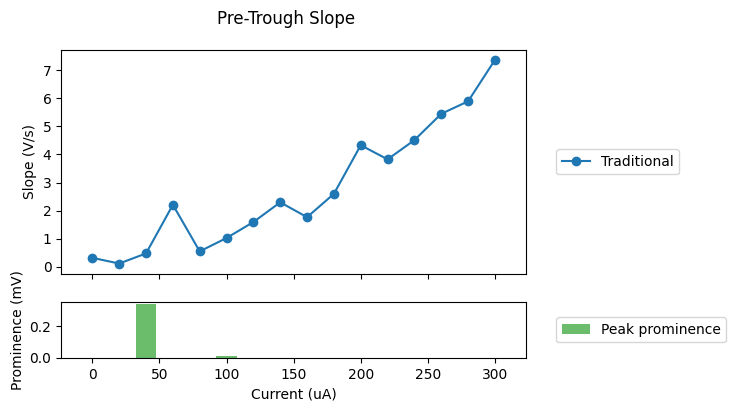

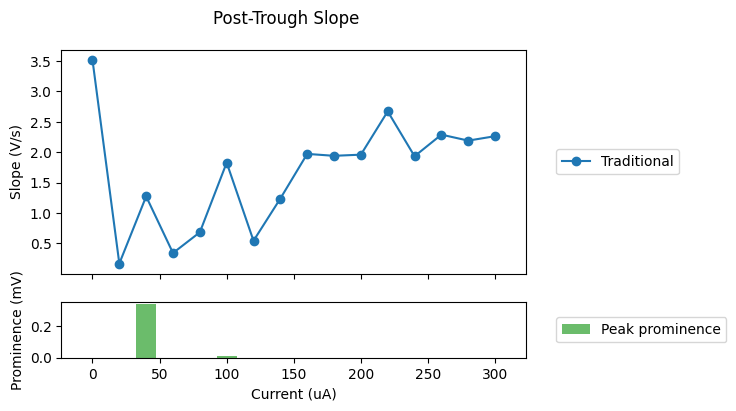

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_26 (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

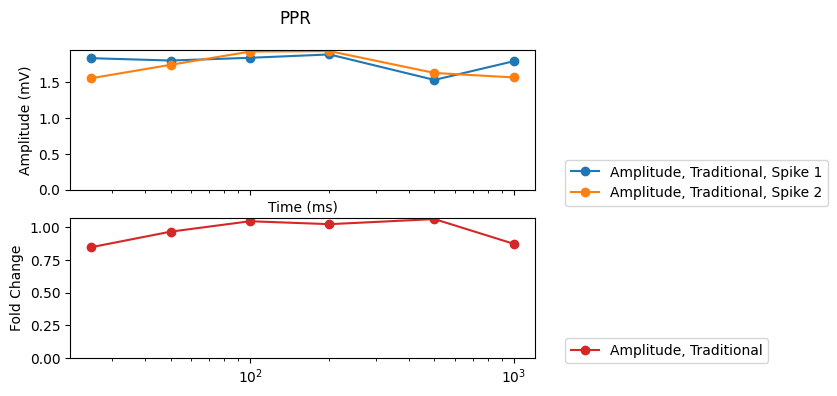

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_26 (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.07377446815371513
PEAK PROMINENCE IS 0.05320897698402405
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.7116886377334595
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.002490520477294922
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 2.3899667263031006
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

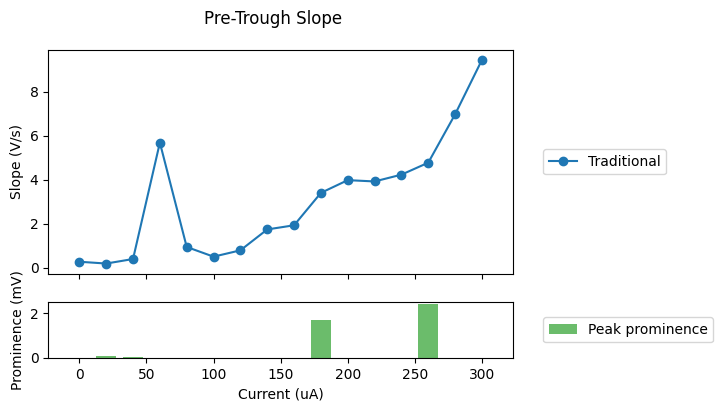

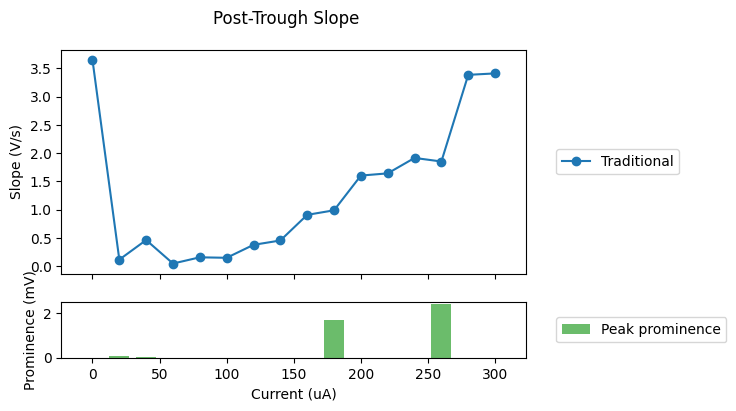

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_26 (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.05319476127624512
PEAK PROMINENCE IS 0.03789210319519043
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

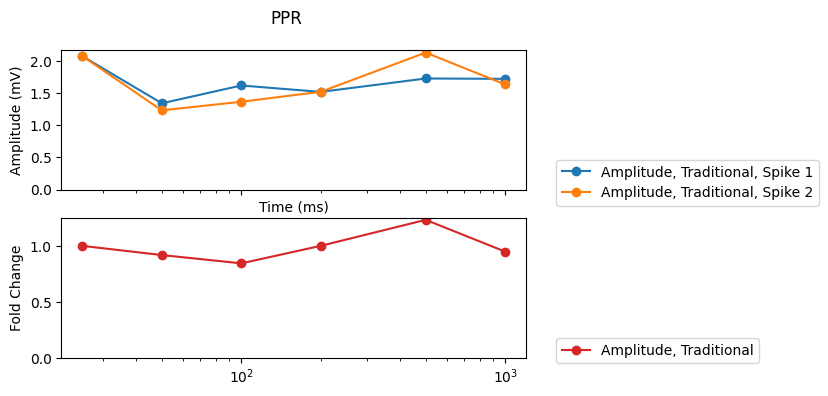

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_26 (20 uA increments)/, Post-IO
PEAK PROMINENCE IS nan
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.32600587606430054
PEAK PROMINENCE IS 0.006874978542327881
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

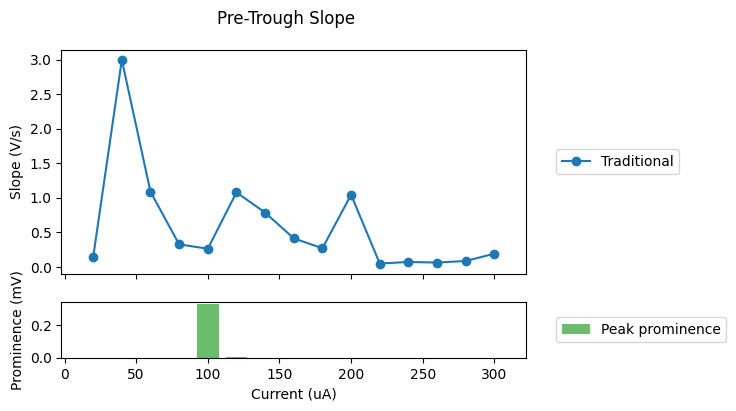

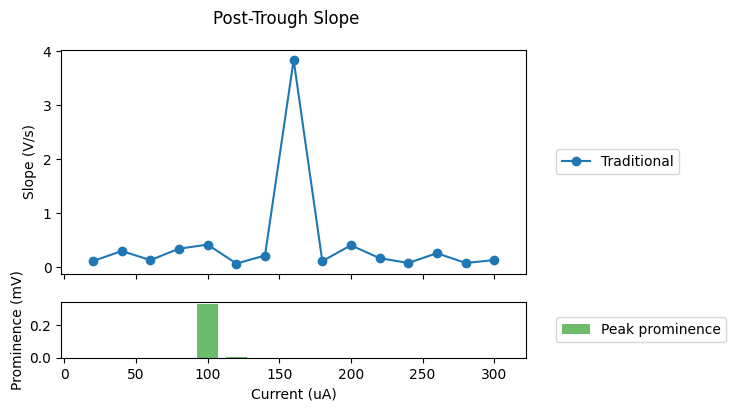

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_26 (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

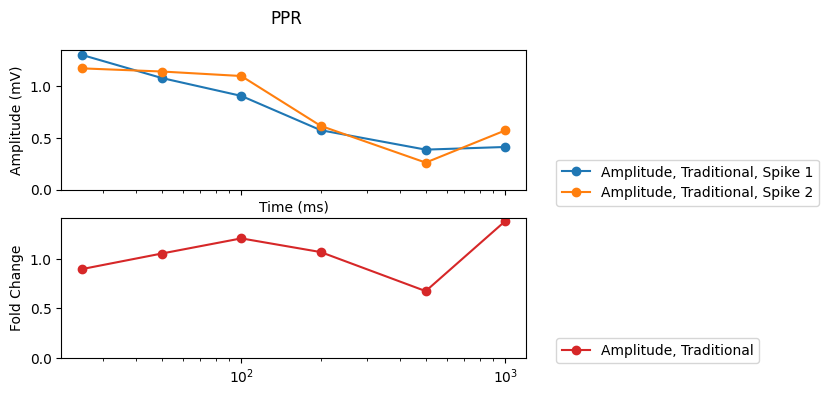

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_28 (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 1.2066920399665833
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.8377425968647003
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.0414502233034
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:189: RuntimeWarning: invalid value encountered in scalar divide
  riseslope = (V[idx_low[-1]] - V[idx_high[-1]]) / ((idx_low[-1] - idx_high[-1]) / f_s)
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: 

PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]


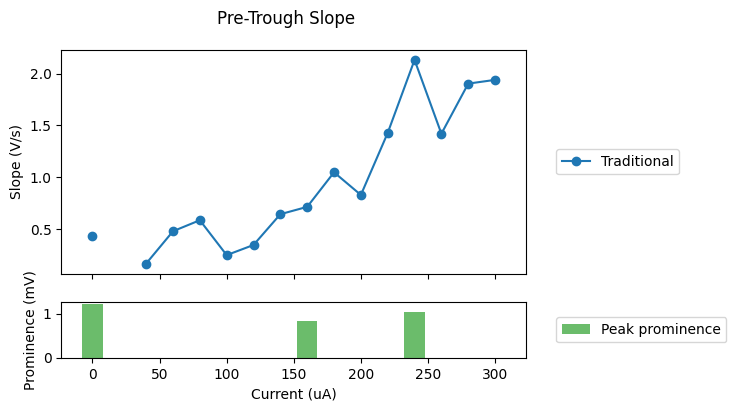

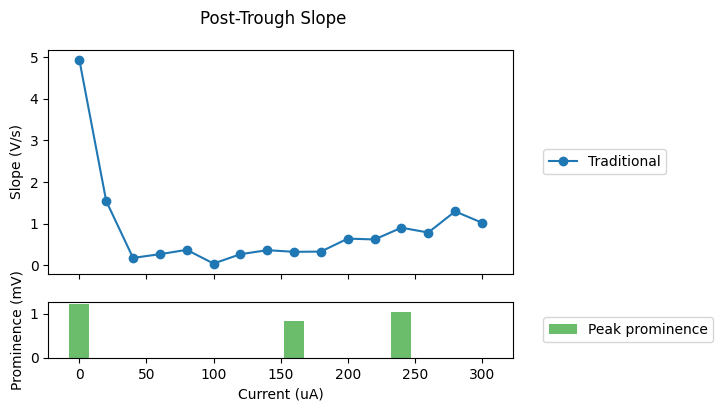

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_28 (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0015926361083984375
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

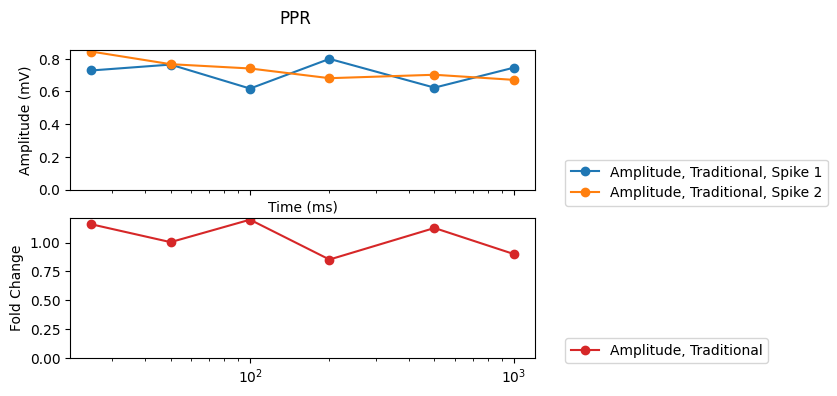

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_28 (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS nan
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

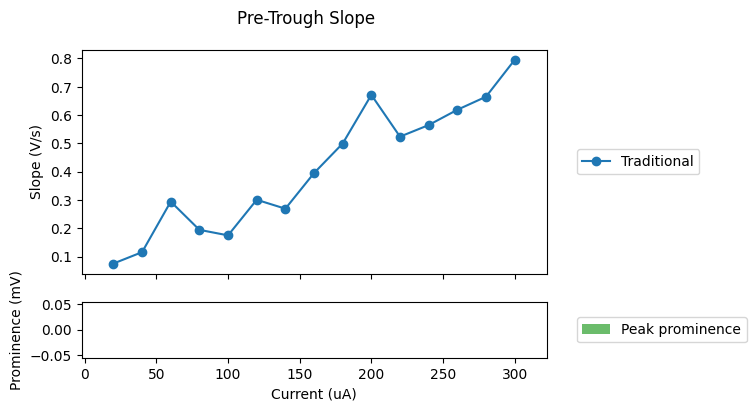

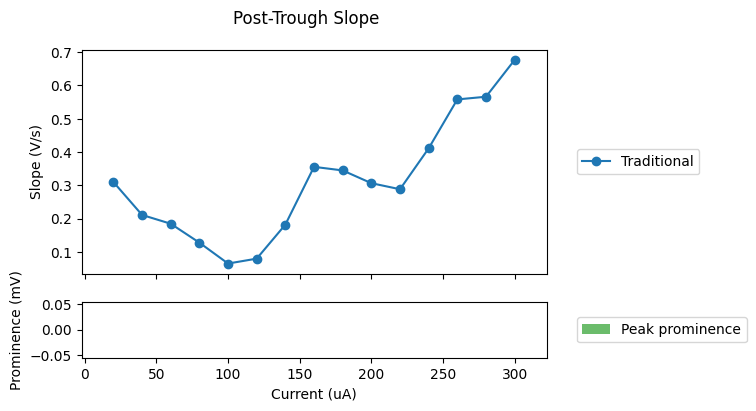

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_28 (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.023061394691467285
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

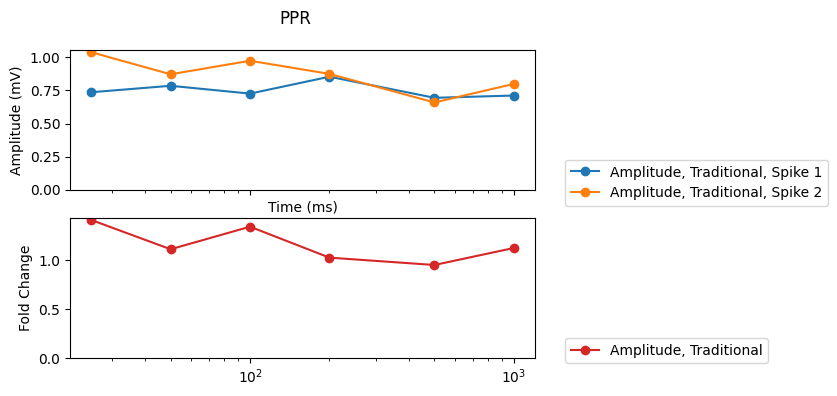

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_28 (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 1.3639940321445465
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.01644948124885559
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.3018361926078796


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

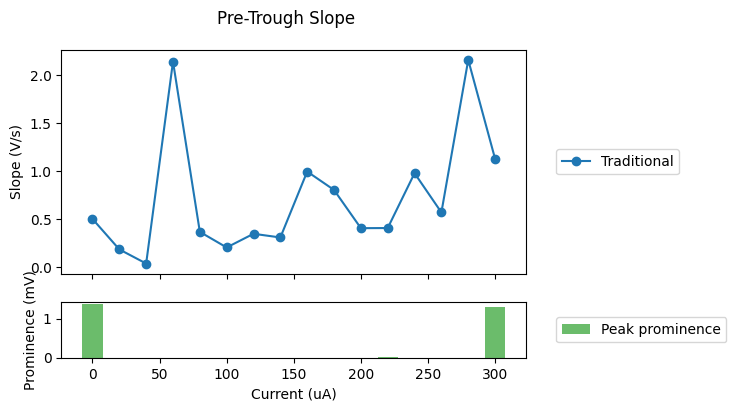

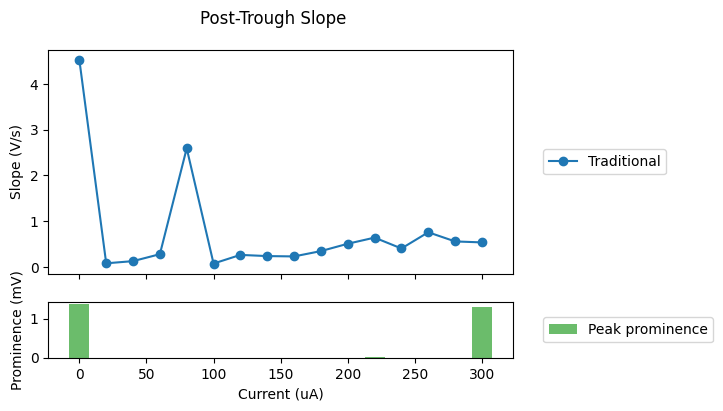

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_06_28 (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.05069085955619812
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

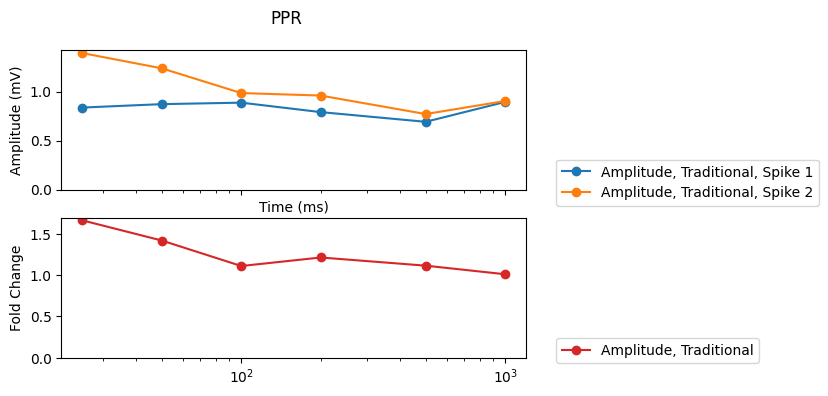

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_02 (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0015912055969238281
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

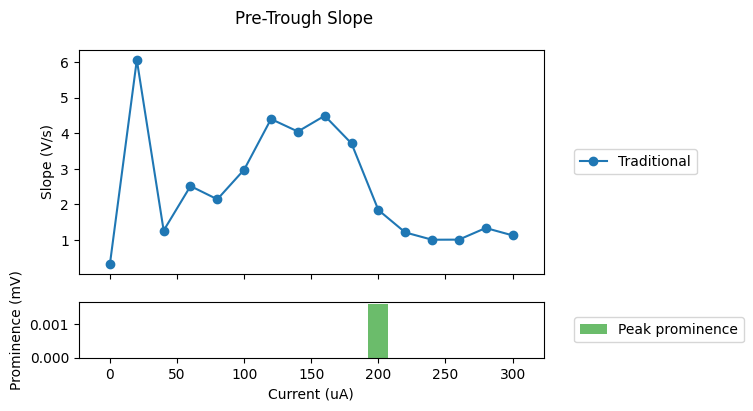

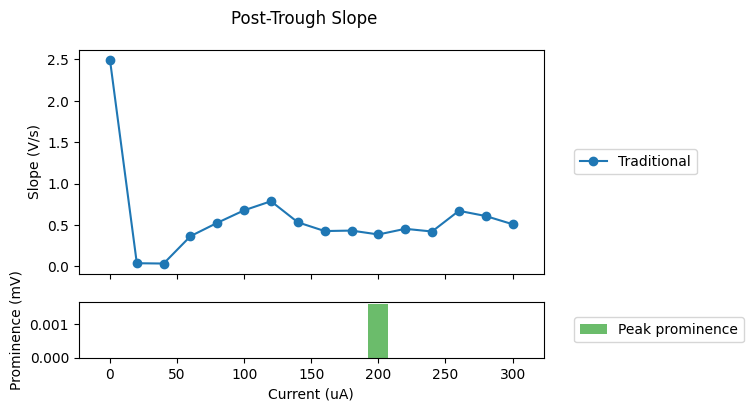

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_02 (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.05642274022102356
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

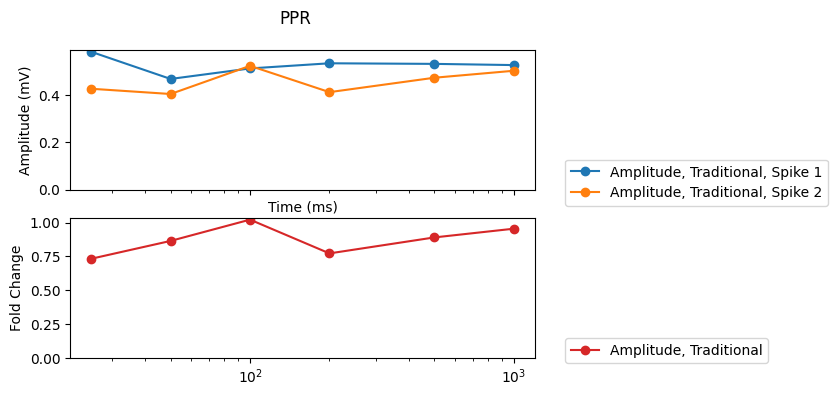

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_02 (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 0.8535320460796356
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

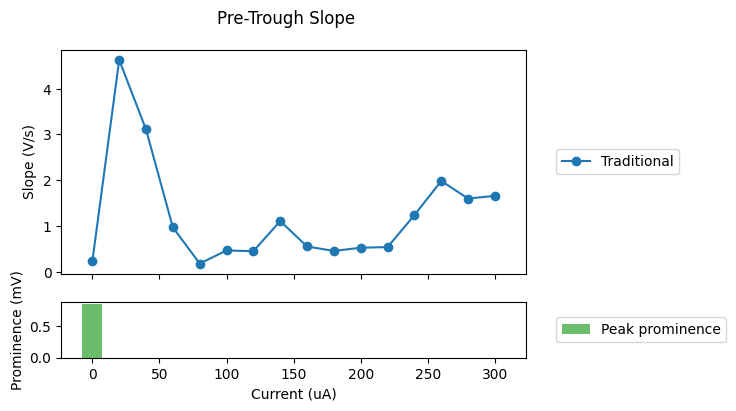

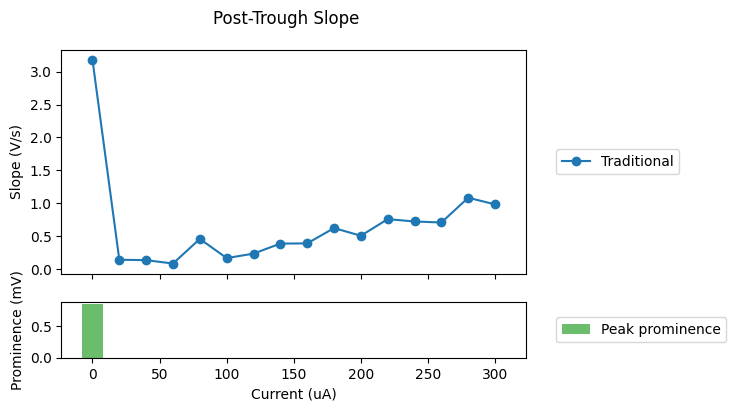

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_02 (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.0023736506700516
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

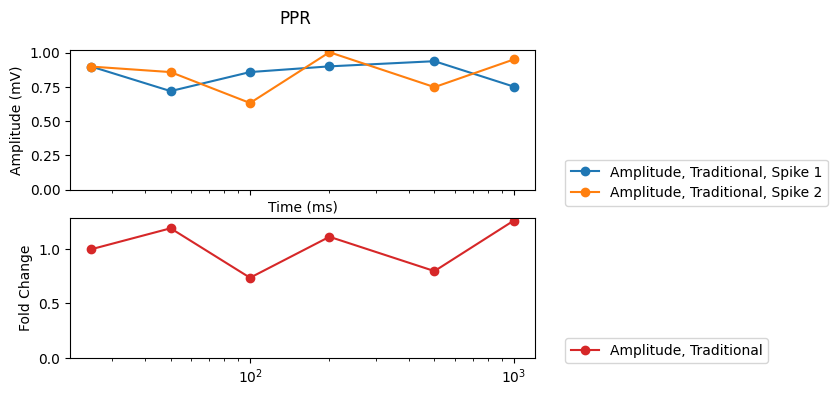

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_02 (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.01183977723121643
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.005863487720489502
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]


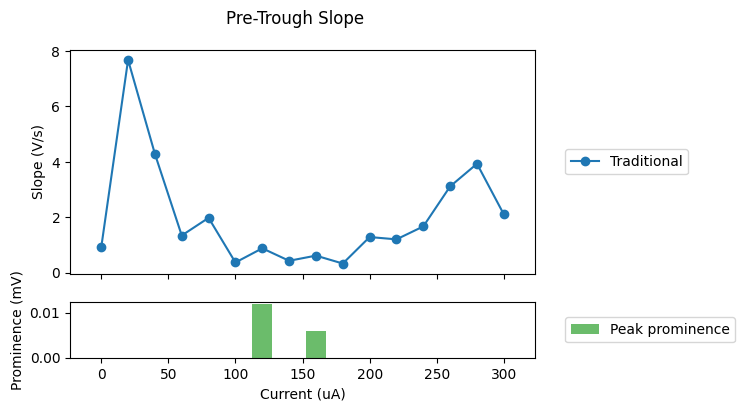

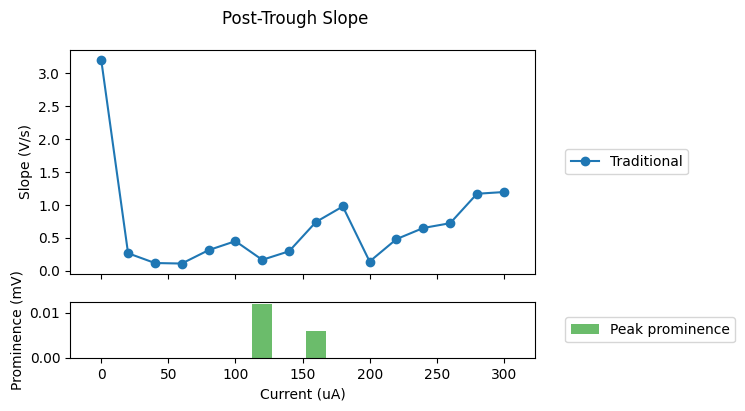

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_02 (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.7799778282642365
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0037724971771240234


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

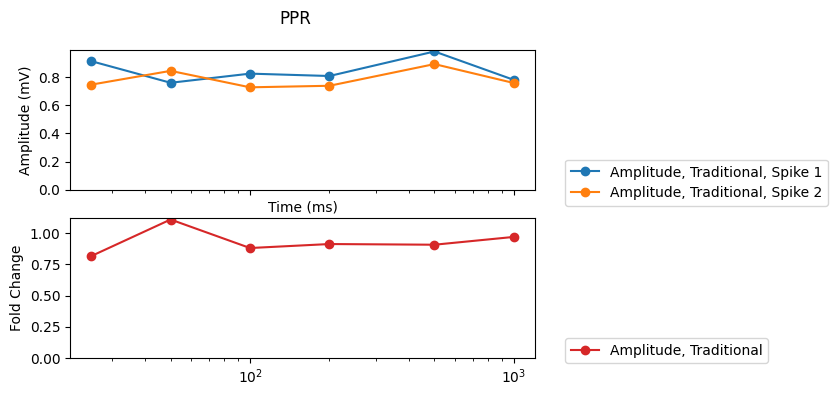

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_03 (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 1.633131057024002
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 2.1259074956178665
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

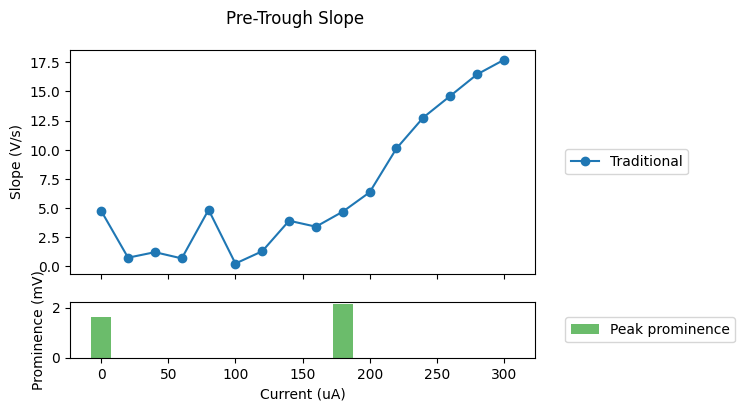

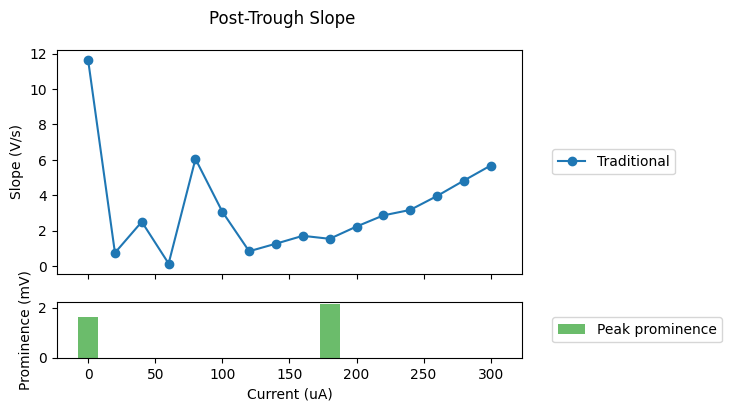

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_03 (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.3224889039993286


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

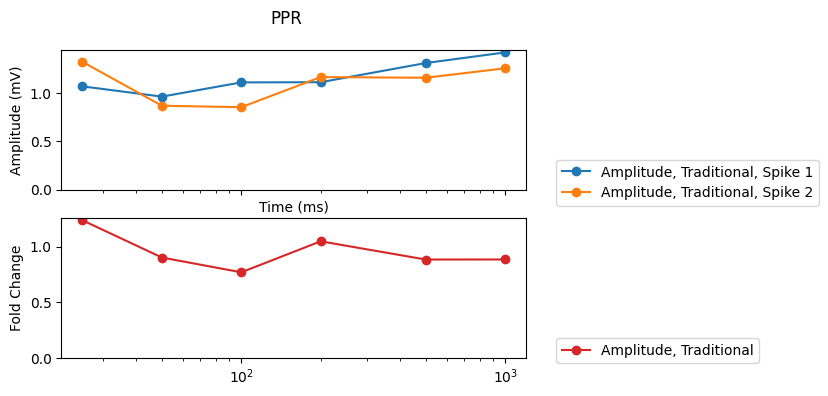

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_03 (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 1.6384794116020203
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.006159305572509766
PEAK PROMINENCE IS 1.0759872496128082
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 2.4846349954605103
PEAK PROMINENCE IS 2.874245762825012


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

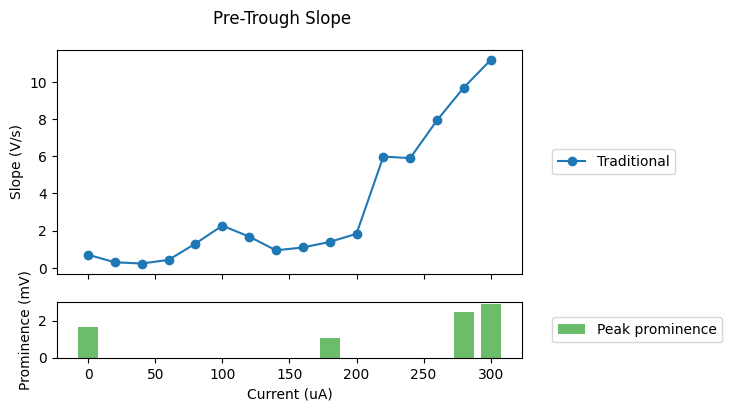

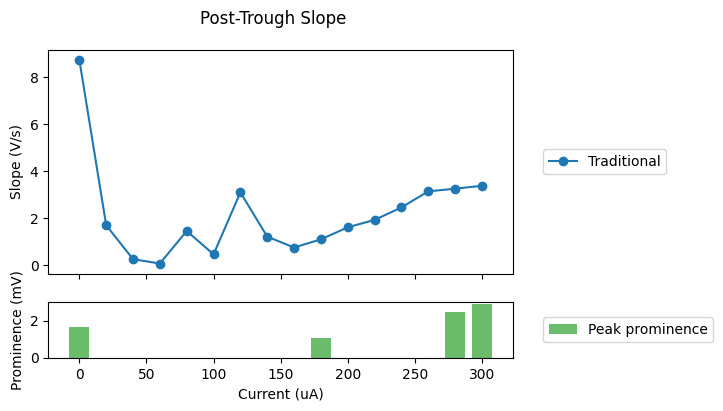

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_03 (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.4893101453781128
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.6378346681594849
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

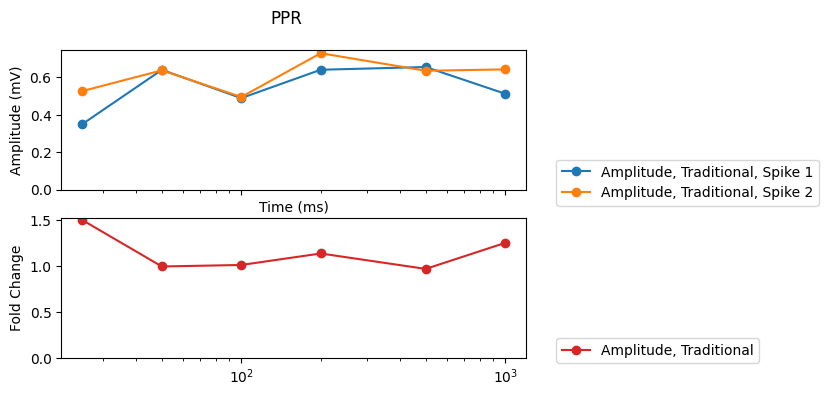

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_03 (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 1.5374251902103424
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.00010817870497703552
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.4386322498321533
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

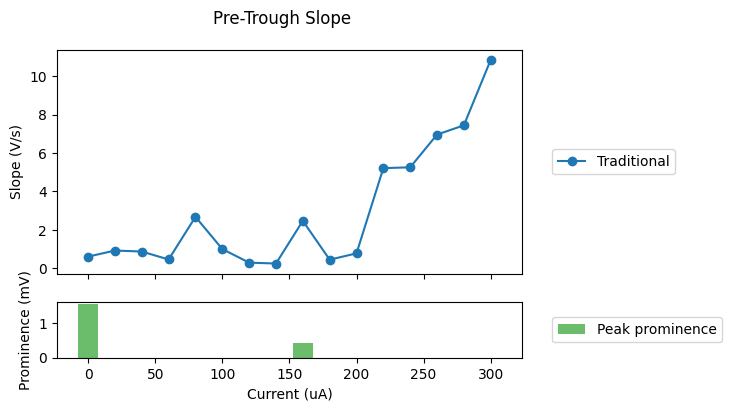

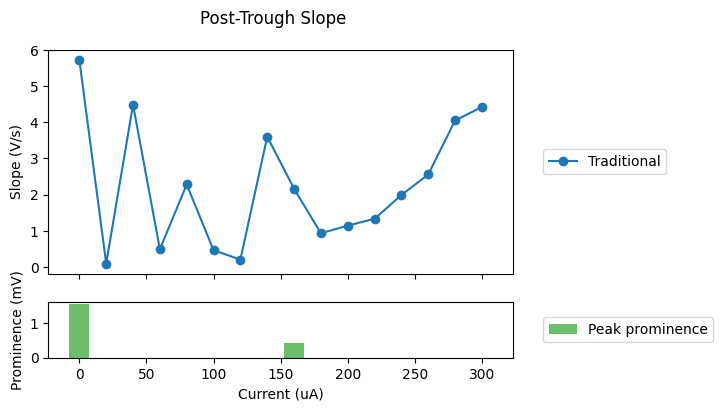

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_03 (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value after spike
idx_high is empty! Using min value after spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.01331627368927002
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value after spike
idx_high is empty! Using min value after spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:174: RuntimeWarning: invalid value encountered in scalar divide
  decayslope = (V[idx_decay[0]] - V[idx_decay[1]]) / ((idx_decay[0] - idx_decay[1]) / f_s)
/tmp/ipykernel_966113/1789259237.py:189: RuntimeWarning: invalid value encountered in scalar divide
  riseslope = (V[idx_low[-1]] - V[idx_high[-1]]) / ((idx_low[-1] - idx_high[-1]) / f_s)
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113

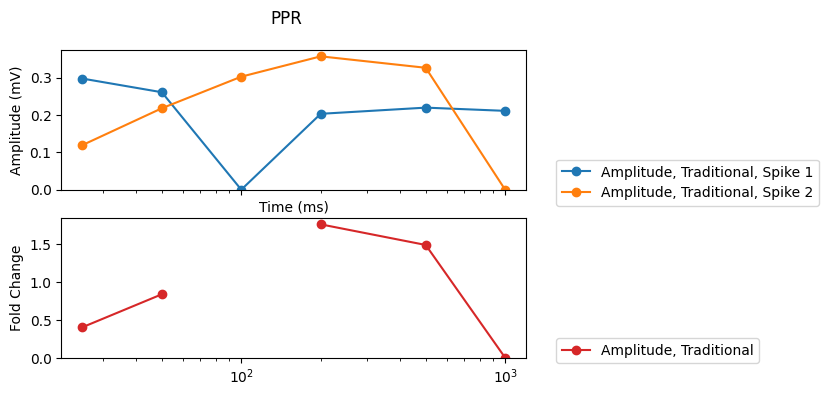

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_05 (GCG, 20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.1815311163663864
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

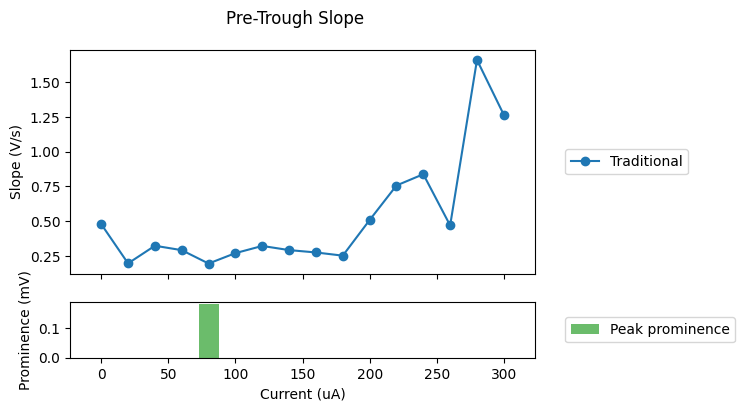

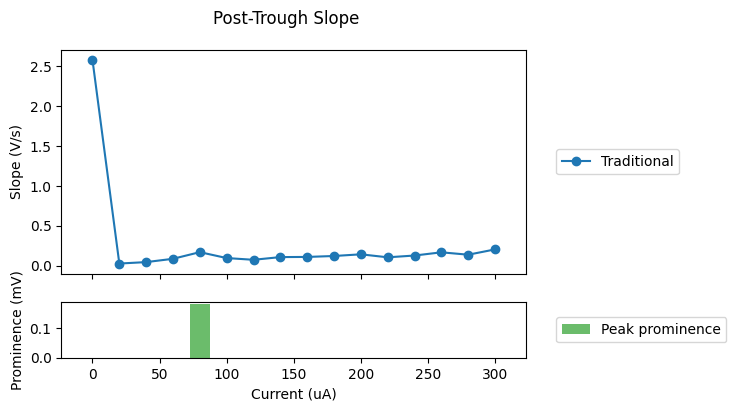

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_05 (GCG, 20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.748560220003128
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.8234367221593857
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

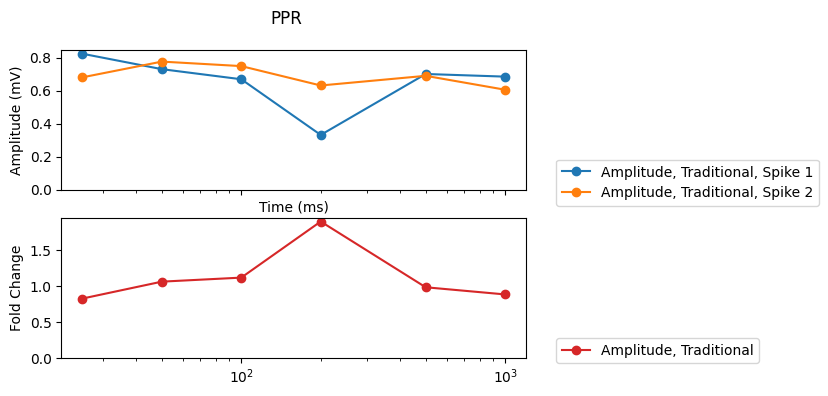

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_05 (GCG, 20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.5556990504264832
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

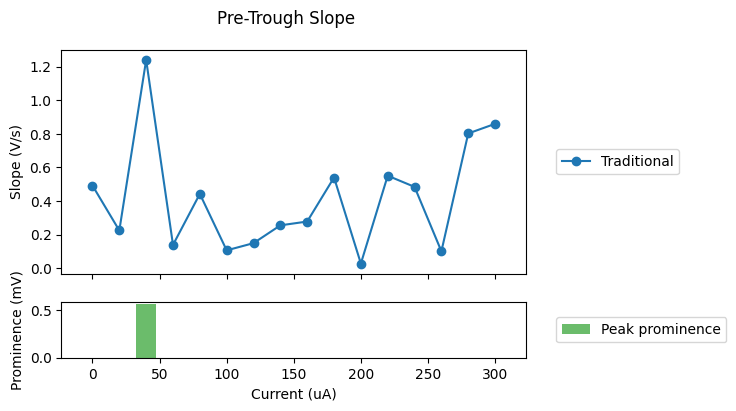

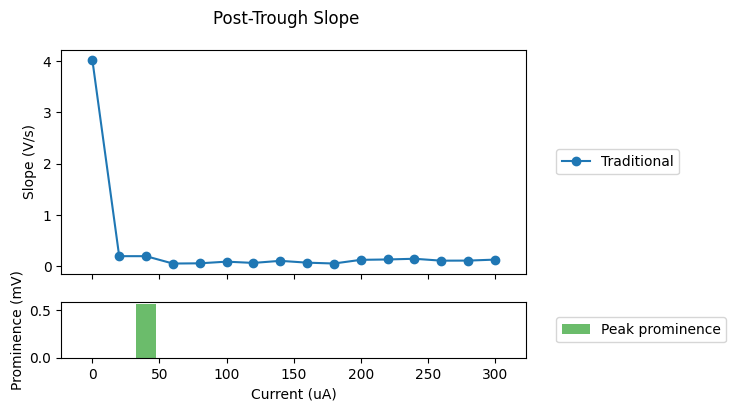

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_05 (GCG, 20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.6335967183113098
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

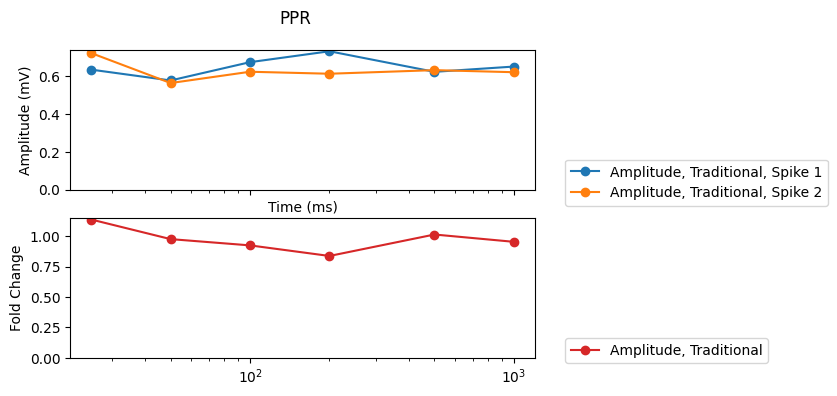

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_05 (GCG, 20 uA increments)/, Post-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.27006833255290985
PEAK PROMINENCE IS 0.543021947145462
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.5842587351799011
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

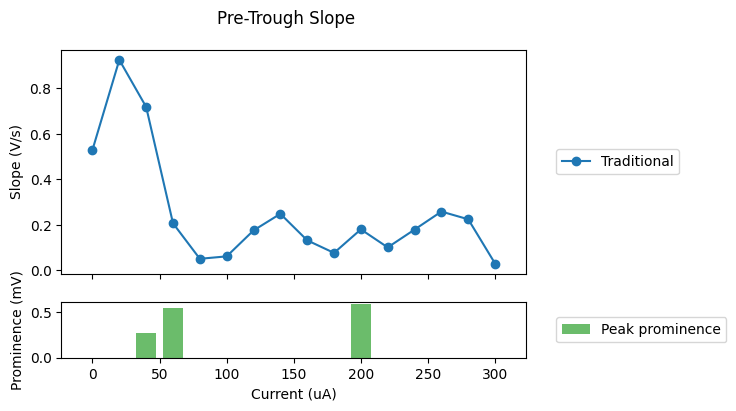

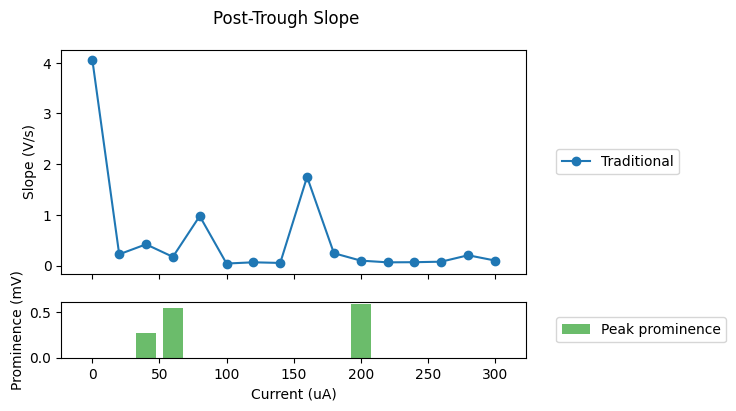

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_05 (GCG, 20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.5053447484970093
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

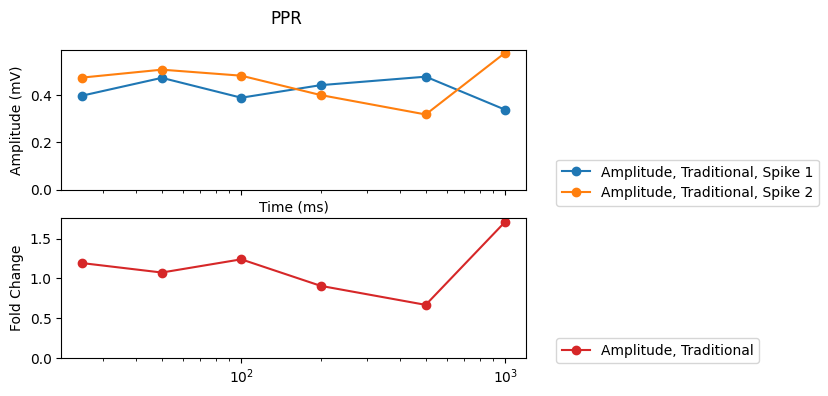

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (1) (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 1.268614649772644
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 3.6999254375696182
PEAK PROMINENCE IS 4.263962425291538
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

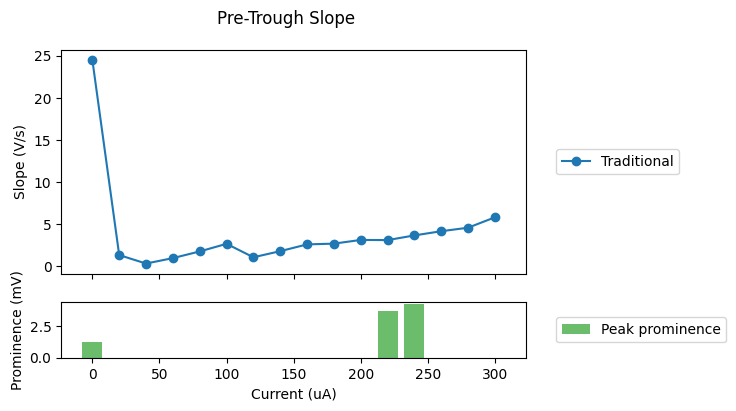

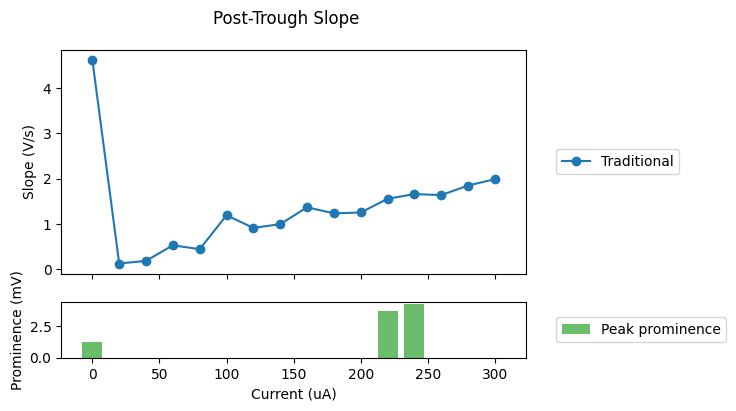

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (1) (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

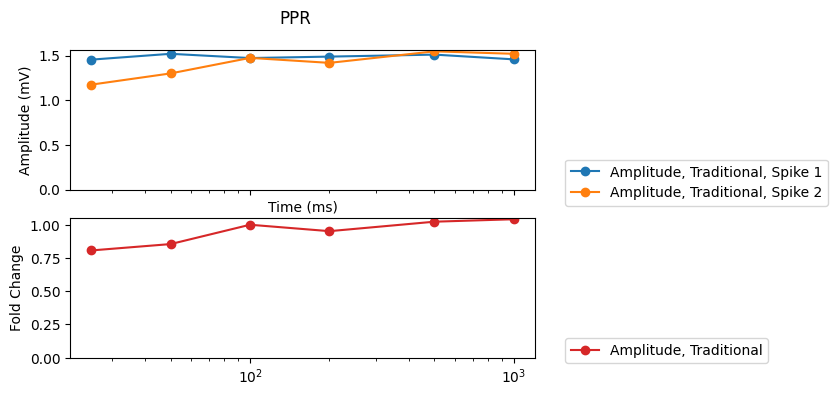

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (1) (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS nan
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.5715895146131516
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.01604175567626953
PEAK PROMINENCE IS 0.014728069305419922
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

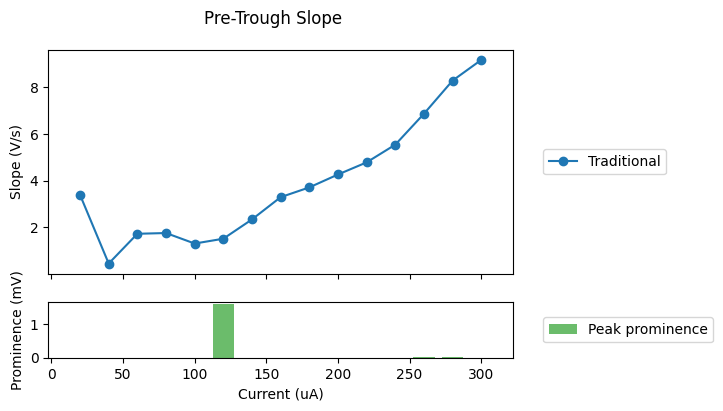

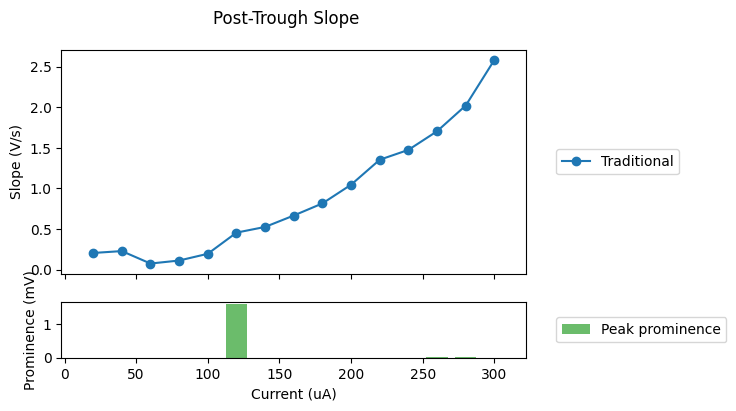

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (1) (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.7491308525204659
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.021598458290100098
PEAK PROMINENCE IS 0.005682945251464844


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

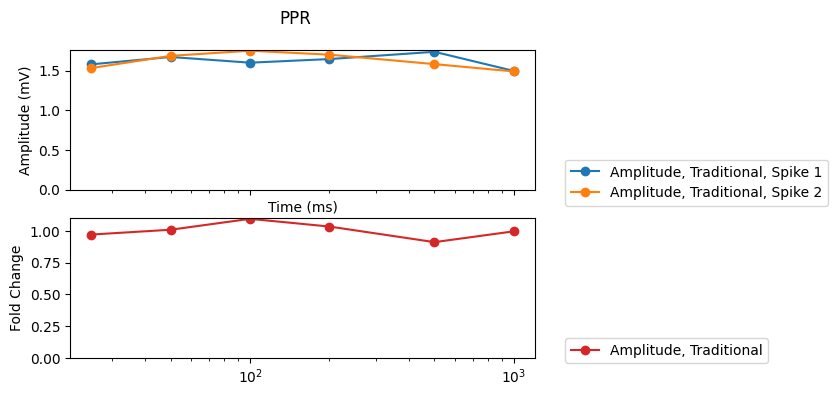

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (1) (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 1.6638914346694946
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.030321836471557617
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0719442367553711


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

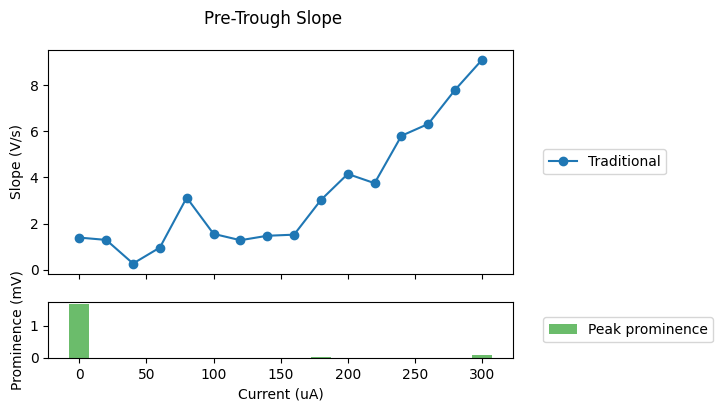

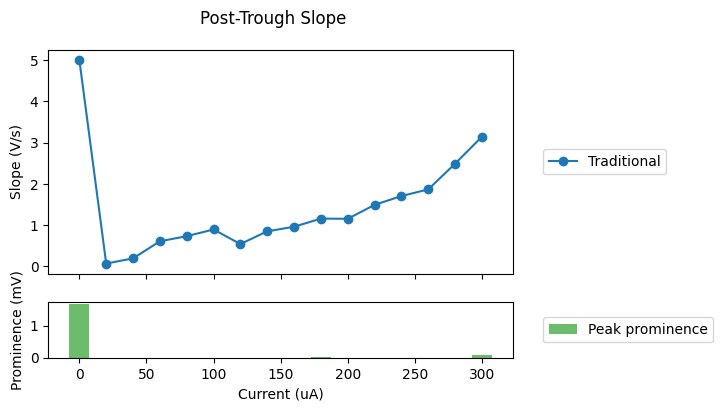

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (1) (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.012750744819641113


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

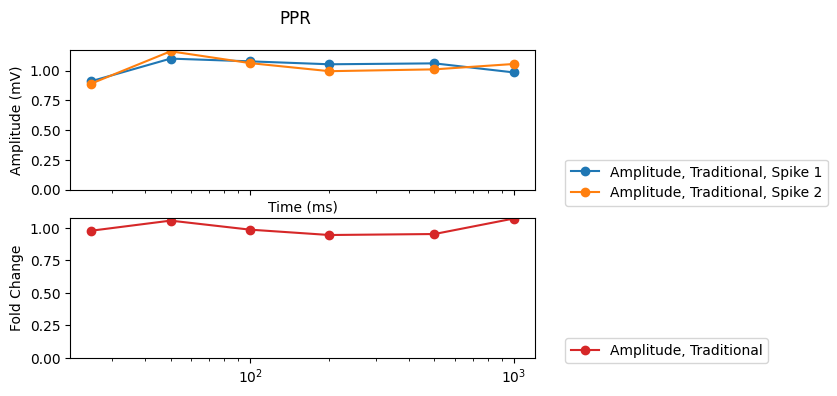

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (2) (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 1.4005679488182068
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

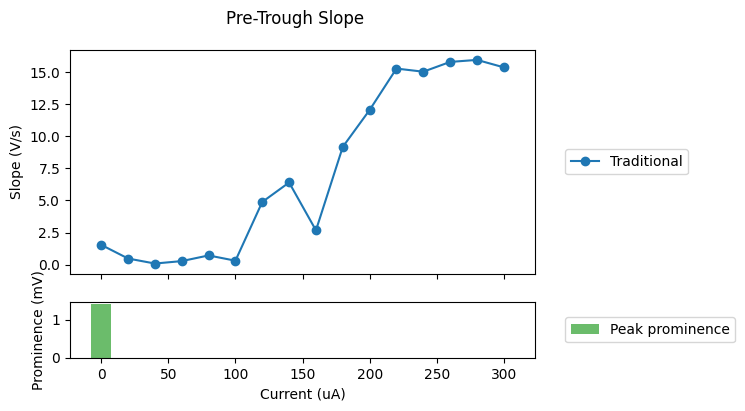

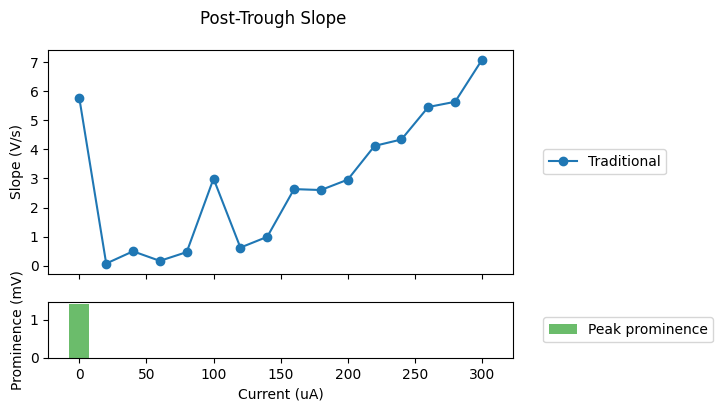

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (2) (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.9603093564510345
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.9911882281303406
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.012730956077575684


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

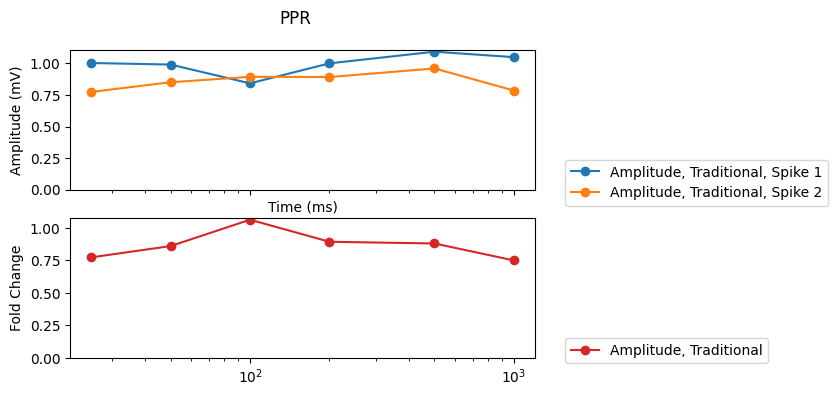

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (2) (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 1.5617868304252625
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 3.5931210070848465
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 4.93779094517231
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

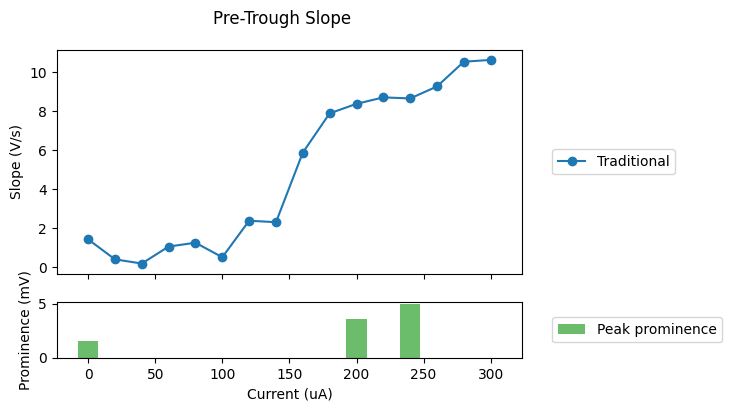

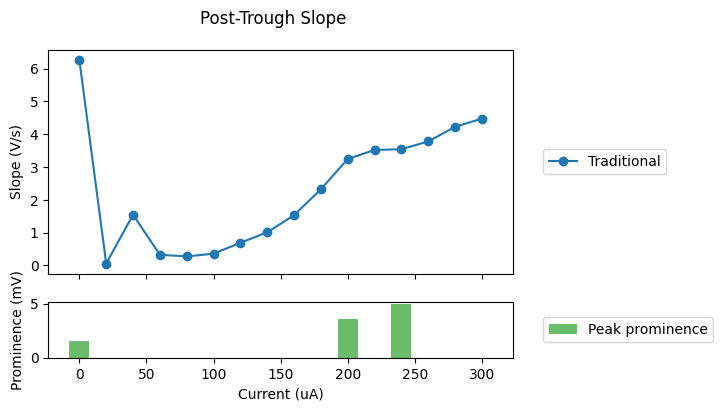

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (2) (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.08332157135009766
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.05468869209289551
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.3002728223800659
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

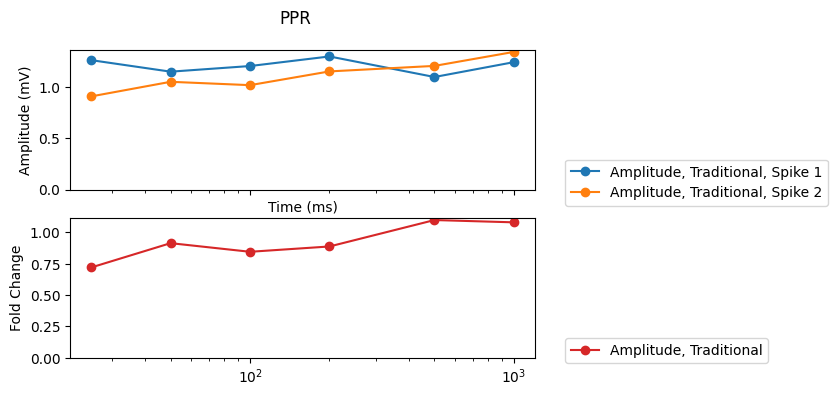

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (2) (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.2364351525902748
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.02070121420547366
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 2.045786678791046
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

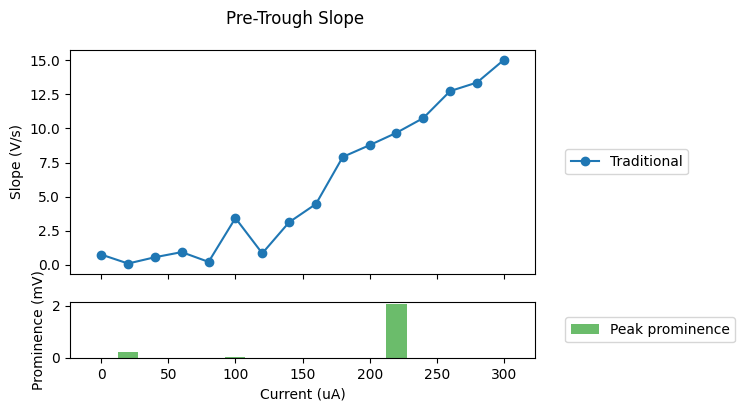

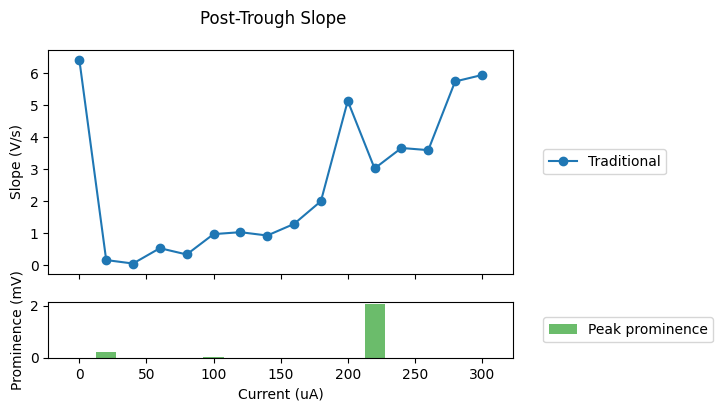

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_09 (2) (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.011398375034332275
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.038715660572052
PEAK PROMINENCE IS 0.7340716123580933
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

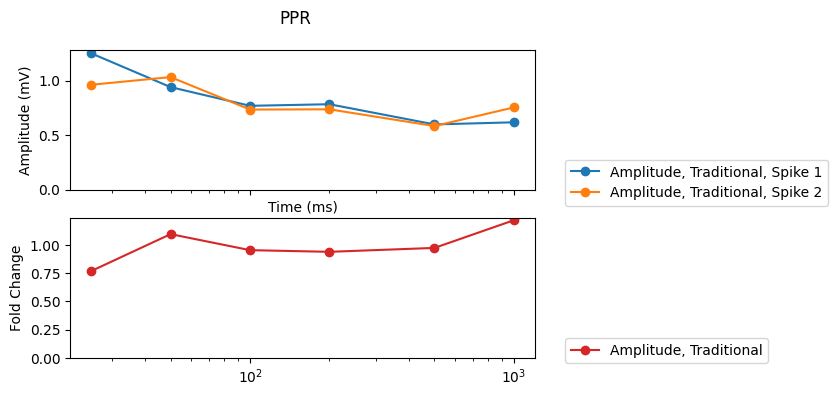

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_10 (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
idx_high is empty! Using min value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 2.0696817860007286
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

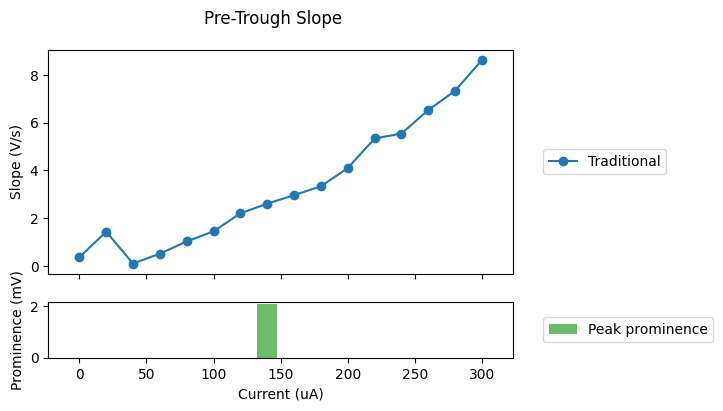

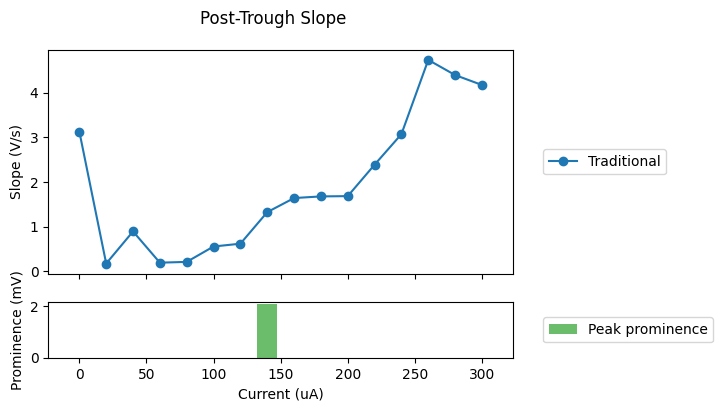

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_10 (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0026067495346069336
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

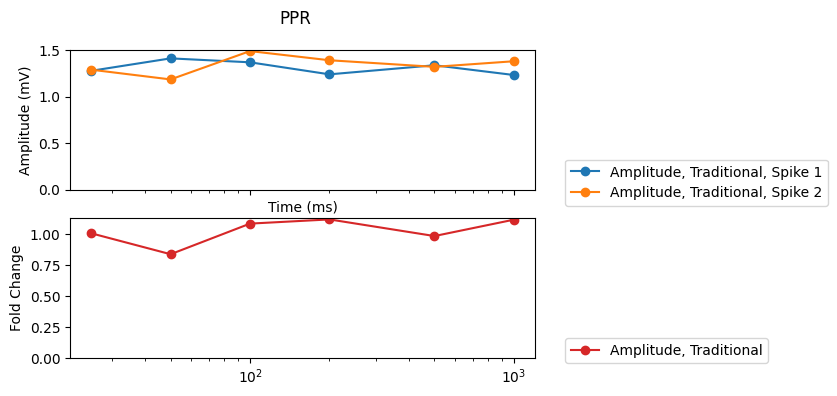

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_10 (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.024417877197265625
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

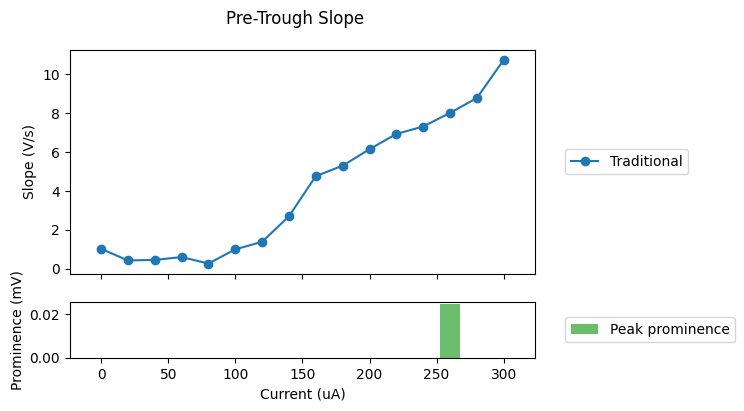

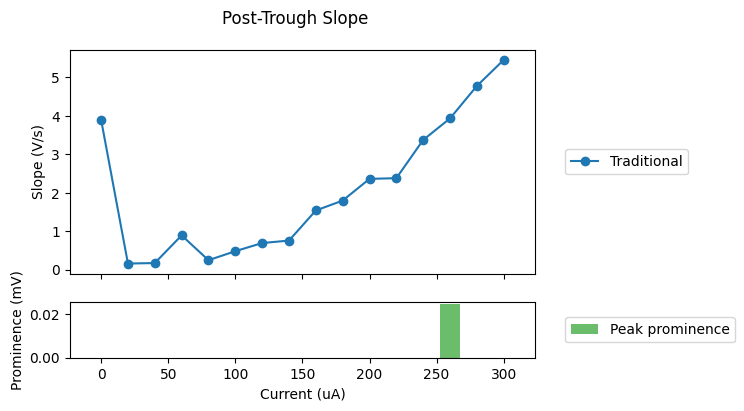

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_10 (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.026010632514953613
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.8964753933250904
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

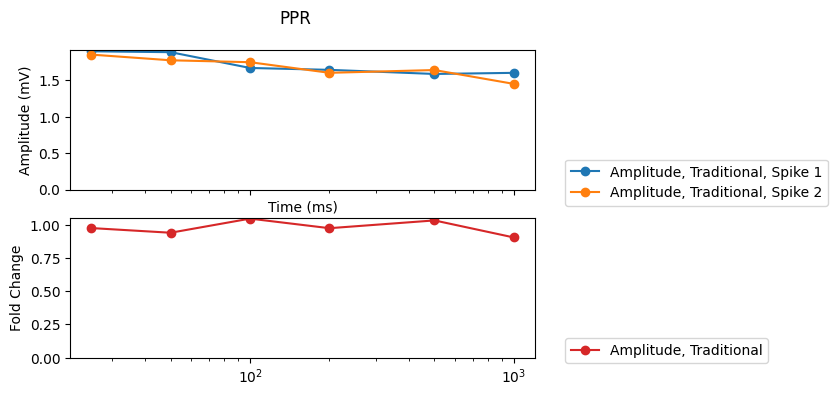

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_10 (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.26416459679603577
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.947123646736145
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

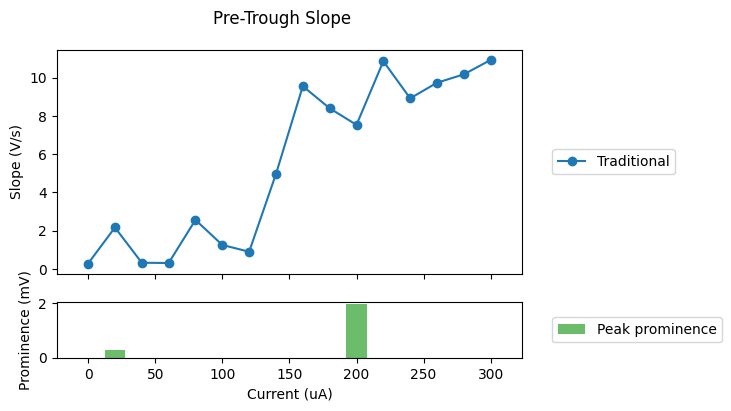

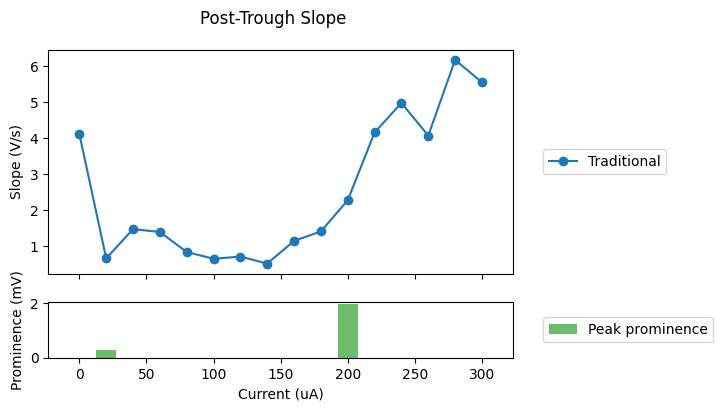

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_10 (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

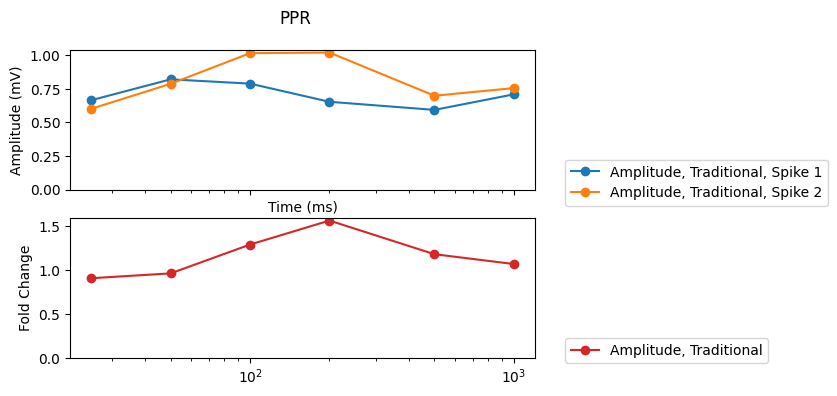

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_18 (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 0.8538962006568909
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

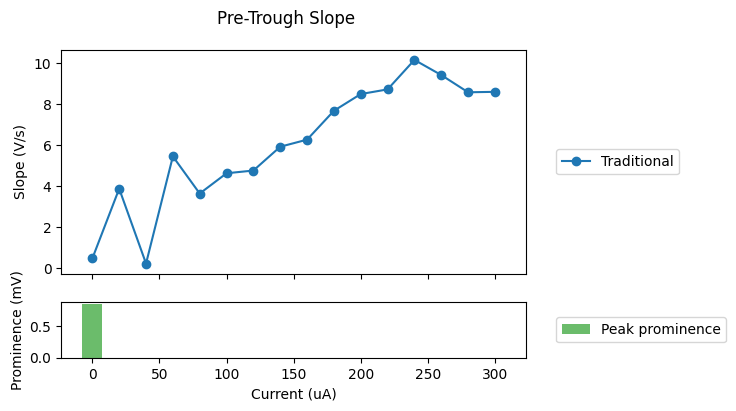

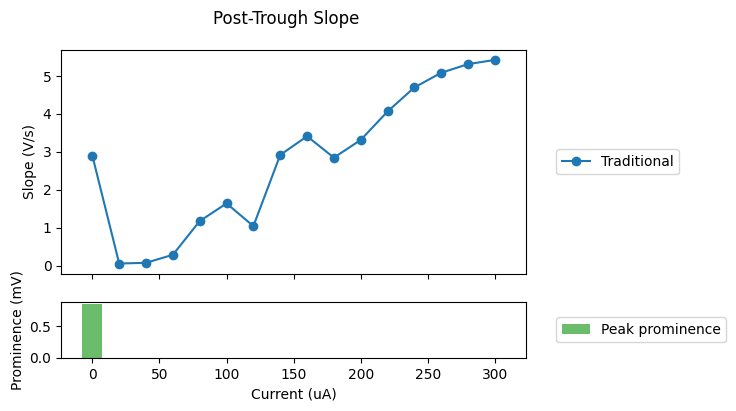

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_18 (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.428928181529045
PEAK PROMINENCE IS 1.436550423502922
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.498682662844658
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

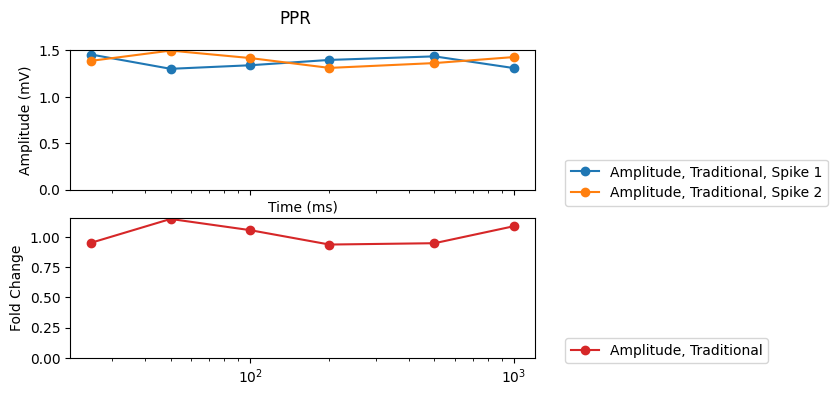

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_18 (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 0.7399065494537354
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.04563247144687921
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.716634288430214
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 5.033345013856888
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

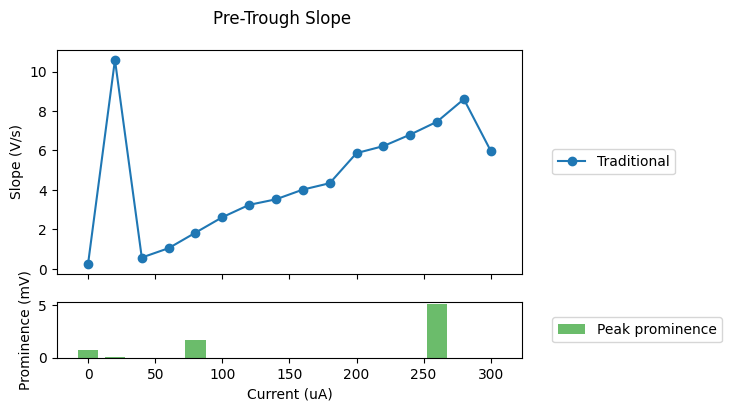

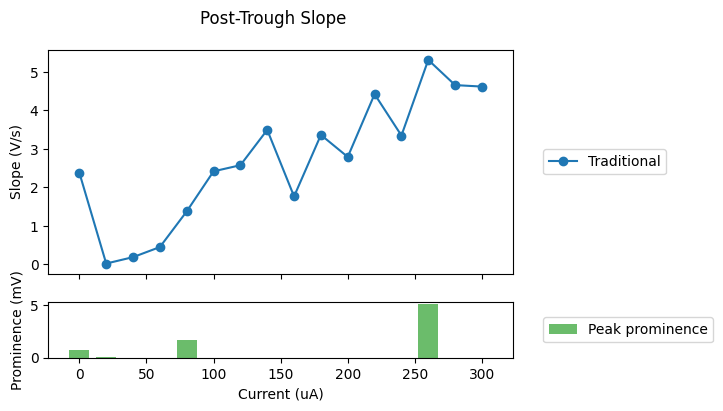

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_18 (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.022467851638793945
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.02700650691986084
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

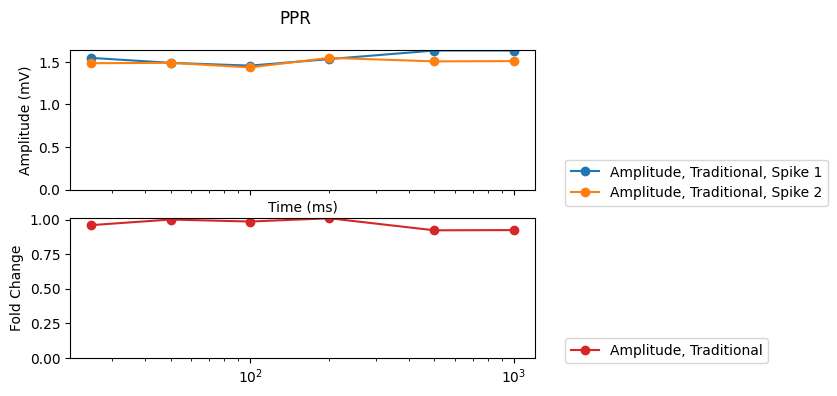

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_18 (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 0.6842375099658966
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

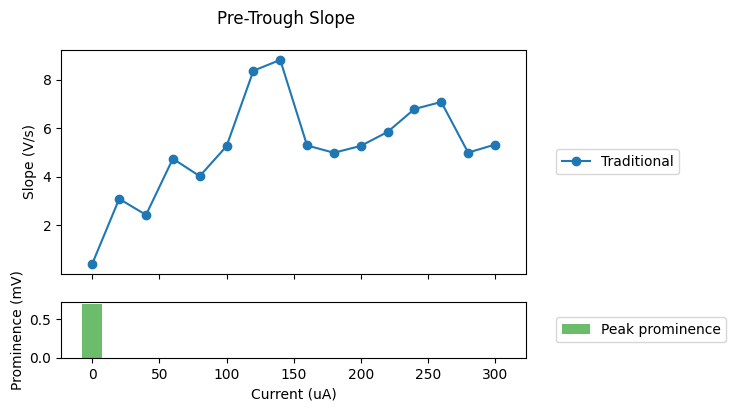

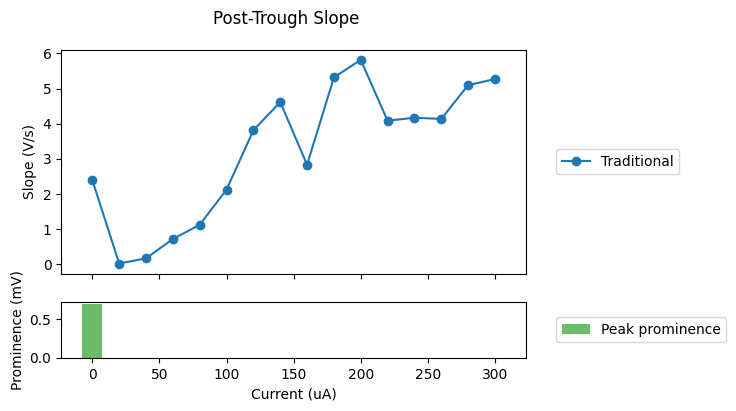

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_18 (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

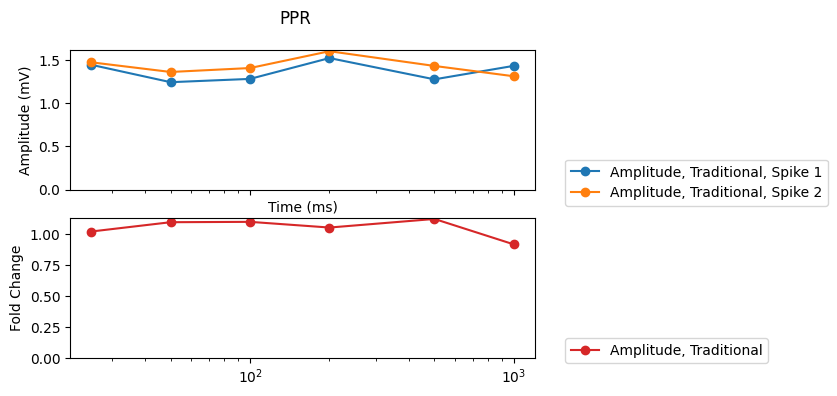

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (1) (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.979486346244812
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.7535284385085106
PEAK PROMINENCE IS 1.8763136863708496
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

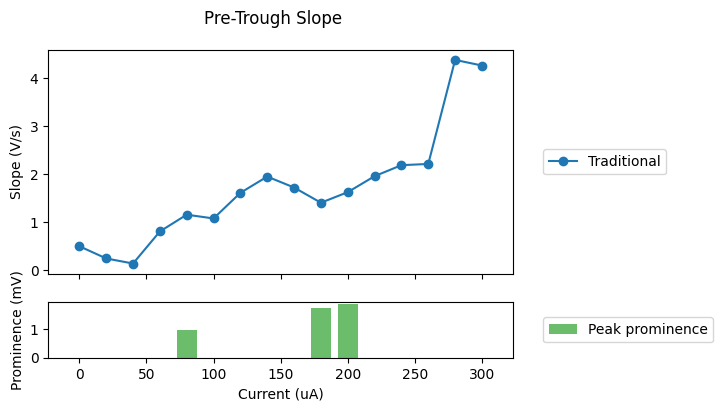

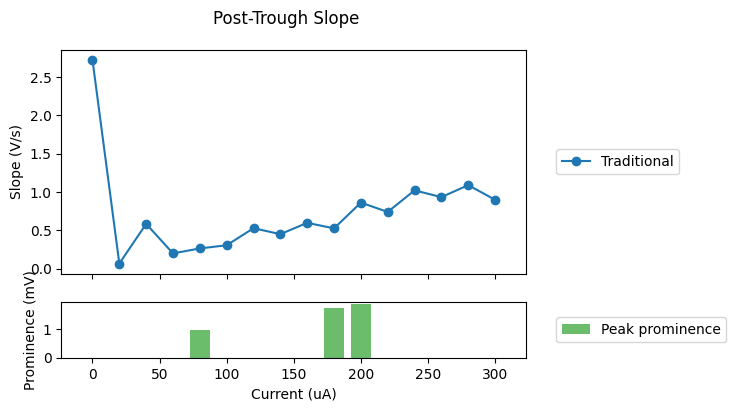

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (1) (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.8521079197525978


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

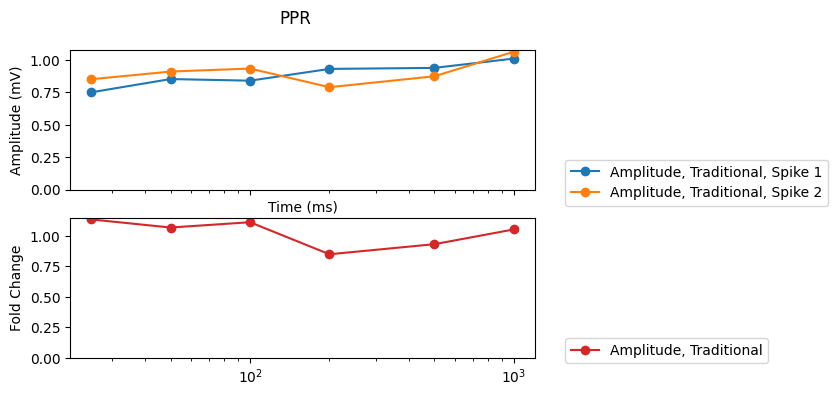

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (1) (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 0.0
idx_high is empty! Using min value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.008758962154388428
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 2.4222381561994553
PEAK PROMINENCE IS 2.862438142299652
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.015003442764282227
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

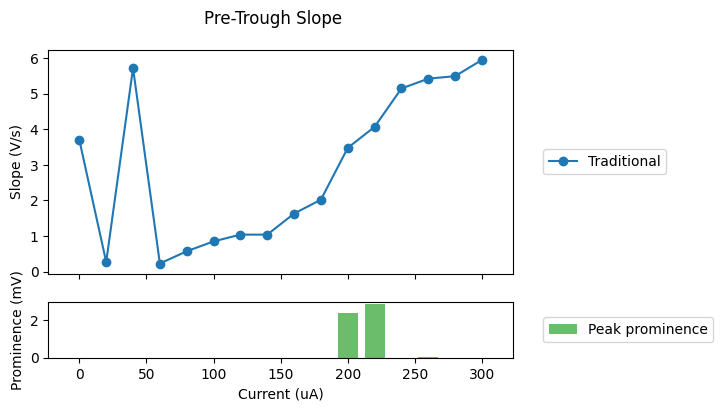

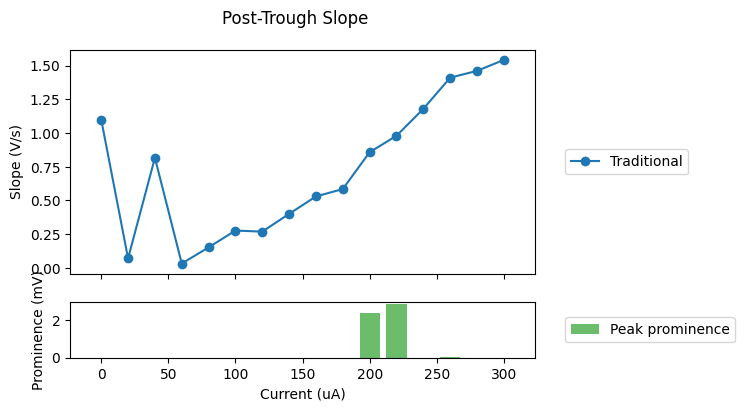

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (1) (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0778883695602417
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

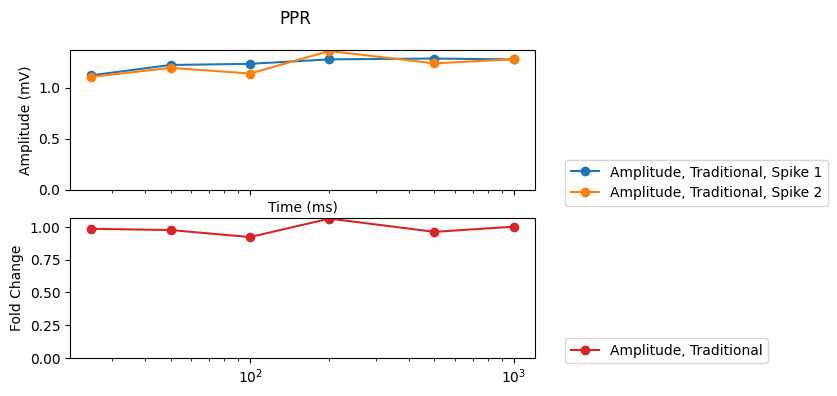

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (1) (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.030855655670166016
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

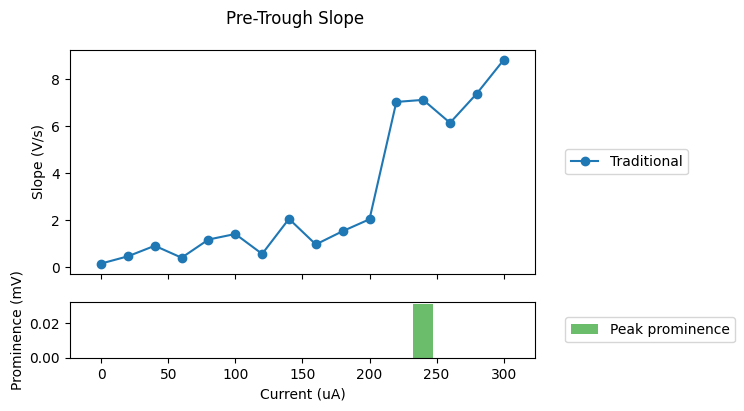

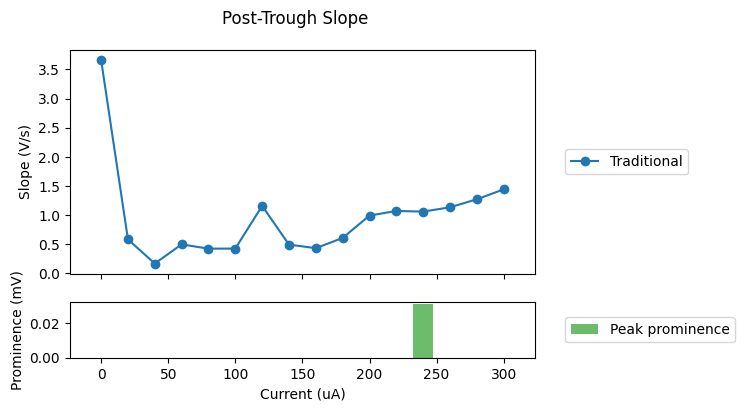

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (1) (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.025154829025268555
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

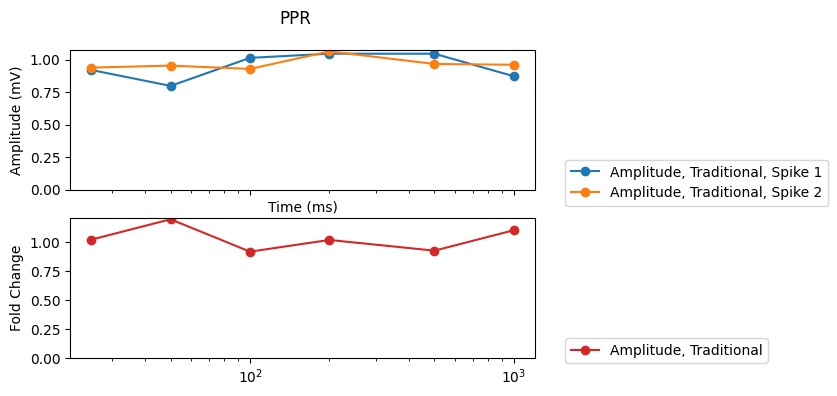

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (2) (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.03953529894351959
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.9124591946601868
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.2878862768411636
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.5907977893948555
PEAK PROMINENCE IS 1.5605133175849915
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

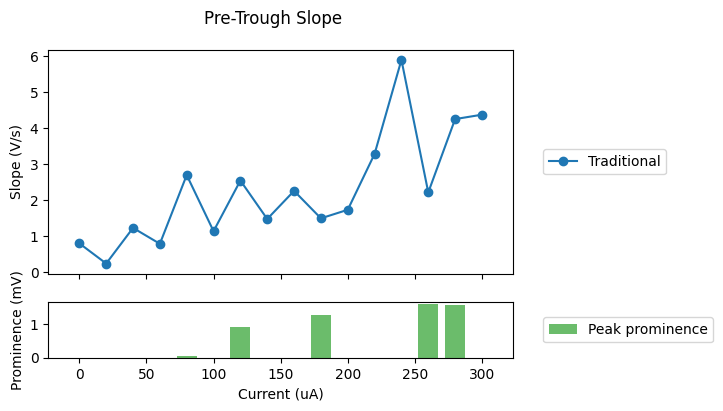

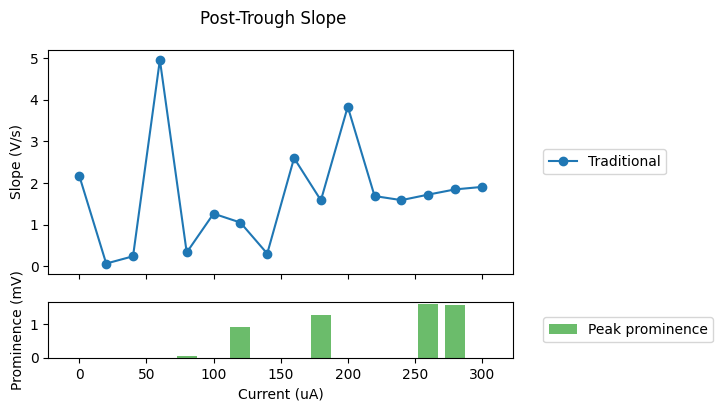

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (2) (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 1.139666497707367


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

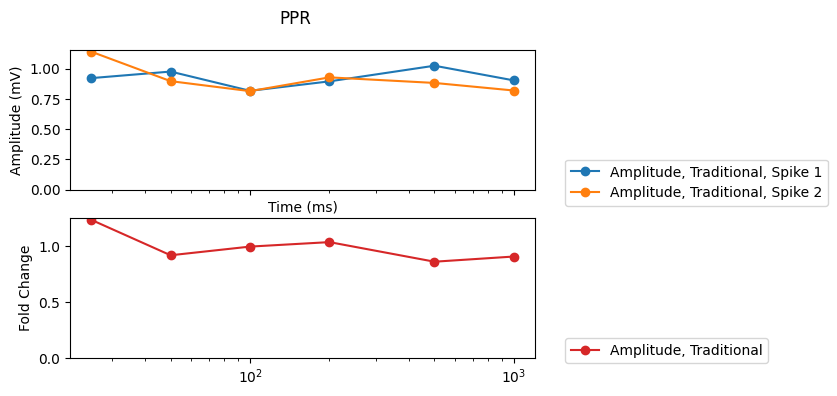

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (2) (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 0.4362294375896454
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

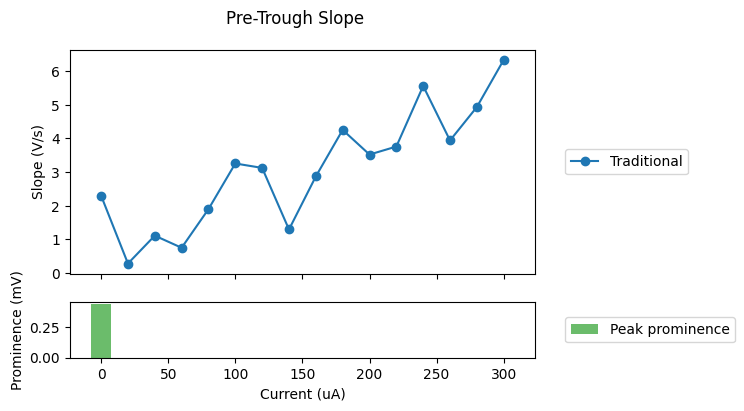

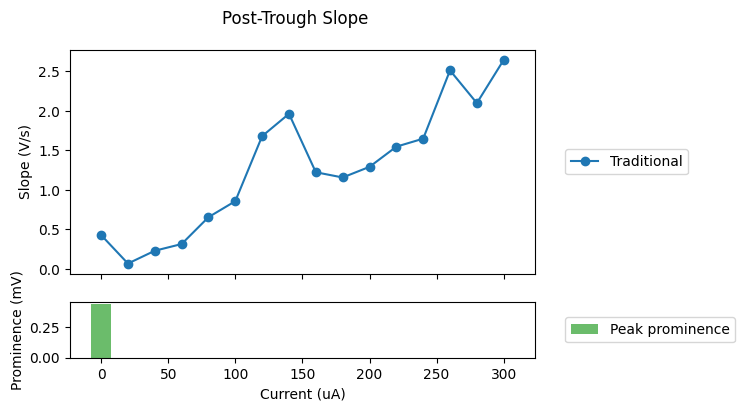

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_19 (2) (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 2.4781980552943423
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

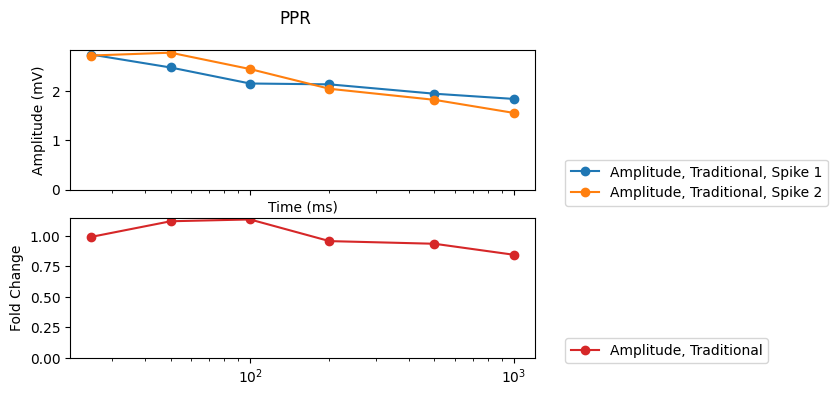

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (1) (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 0.7856321632862091
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 3.4372843354940414
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0007658004760742188
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

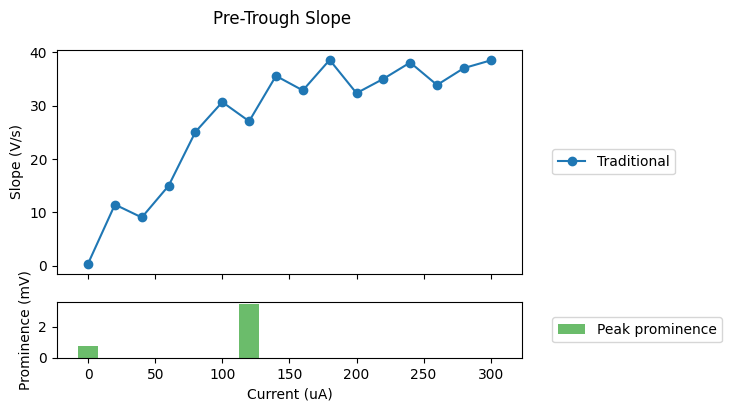

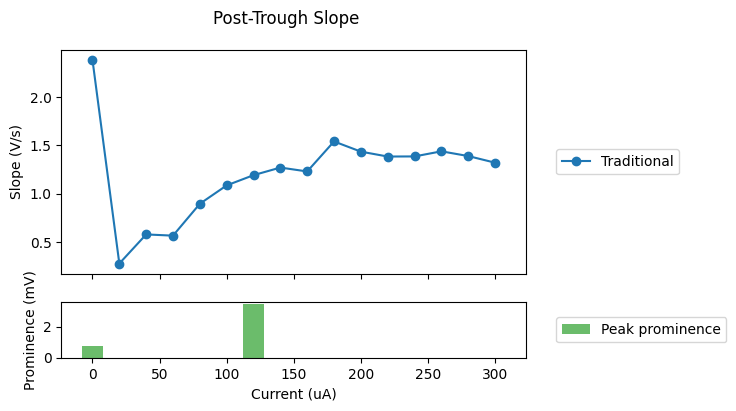

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (1) (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.010004699230194092
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

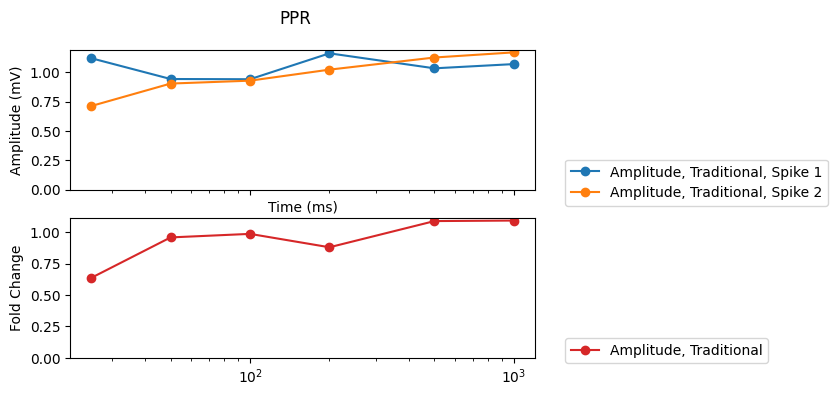

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (1) (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.019175291061401367
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

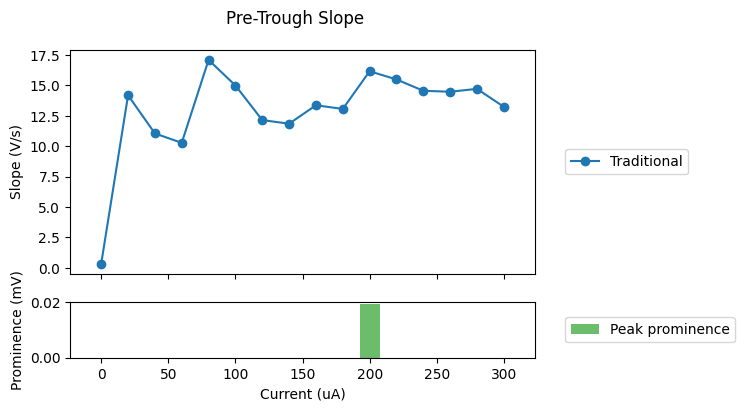

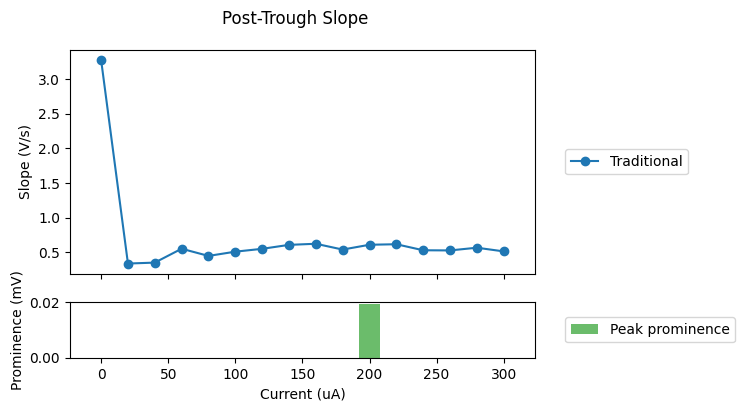

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (1) (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.8016310334205627
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

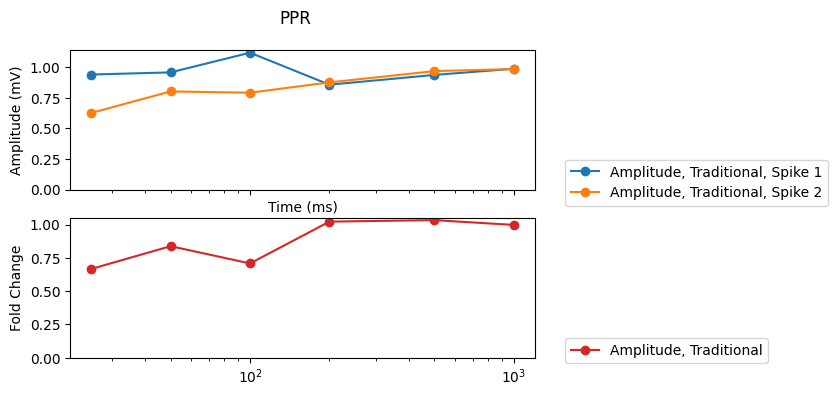

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (1) (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.014822781085968018
PEAK PROMINENCE IS 0.04935956001281738
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 2.544187515974045
PEAK PROMINENCE IS 2.662386268377304
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

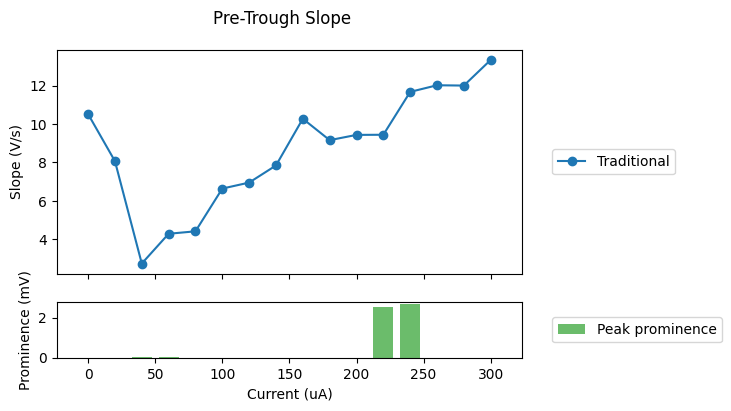

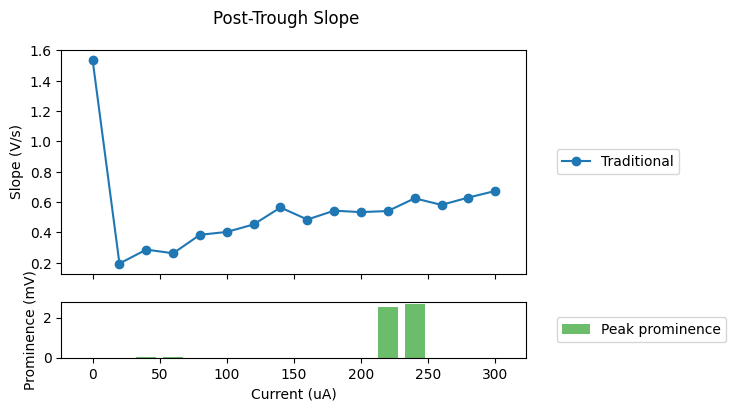

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (1) (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.030138134956359863
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

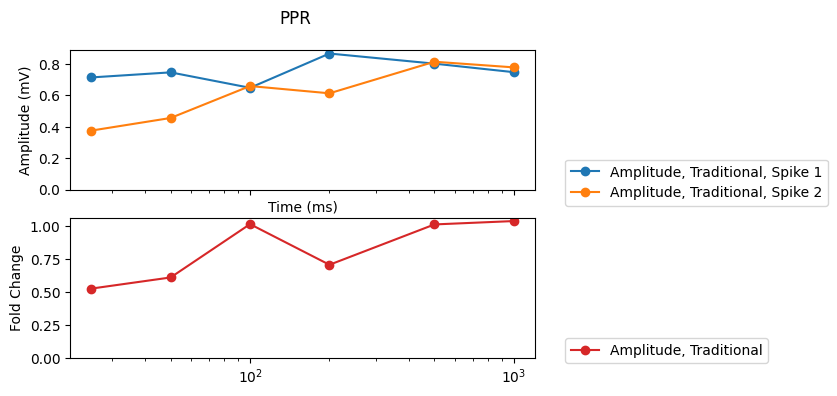

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (2) (20 uA increments)/, Pre-IO
PEAK PROMINENCE IS 0.6563725471496582
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0013732463121414185
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

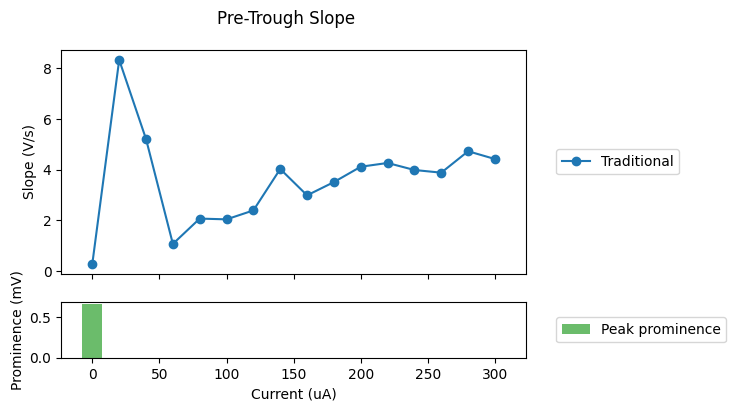

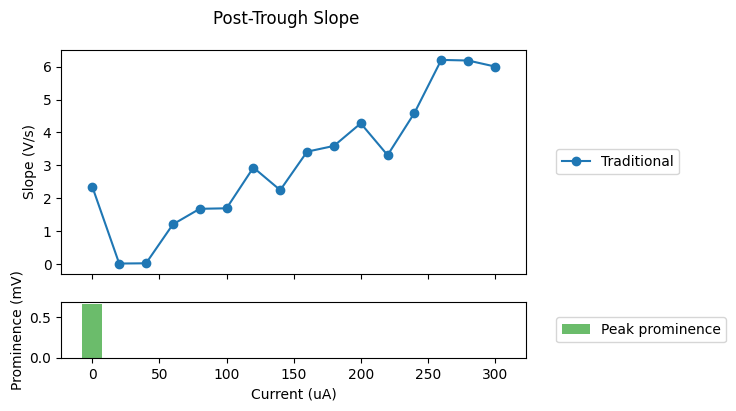

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (2) (20 uA increments)/, Pre-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

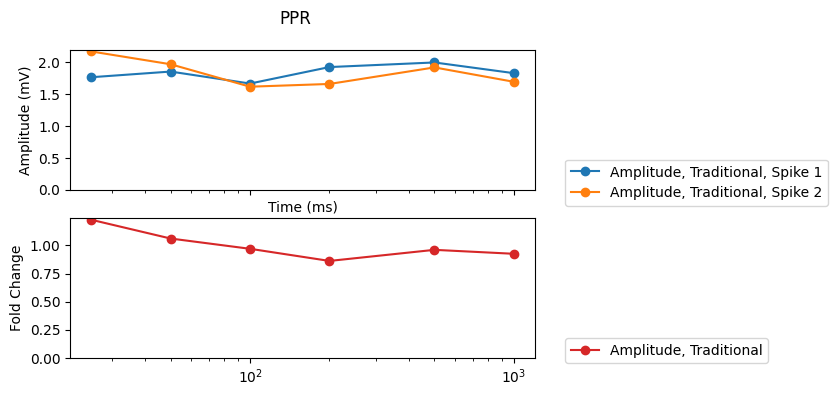

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (2) (20 uA increments)/, CCh-IO
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 3.222361993044615
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

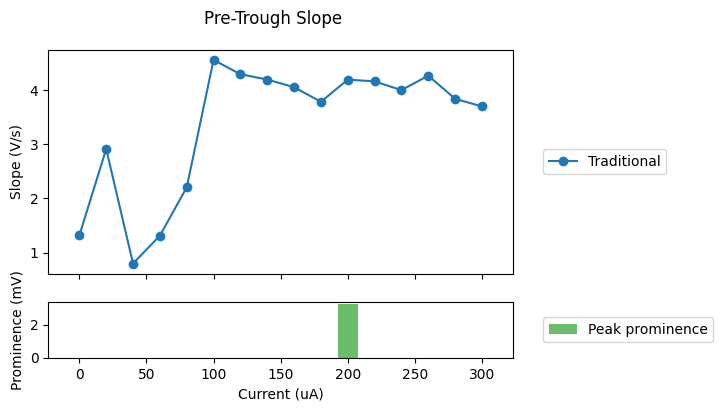

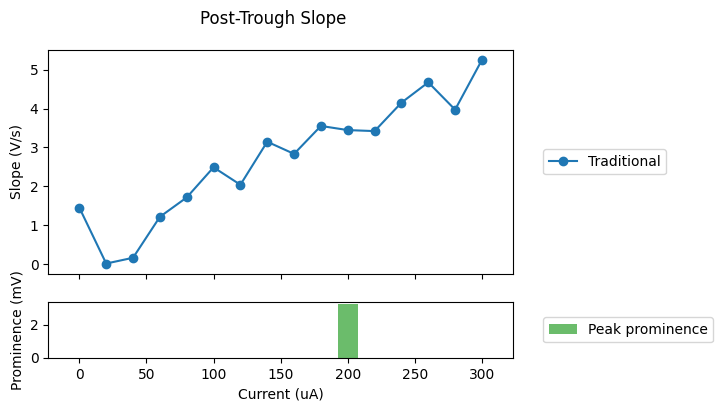

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (2) (20 uA increments)/, CCh-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 2.0986389815807343
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

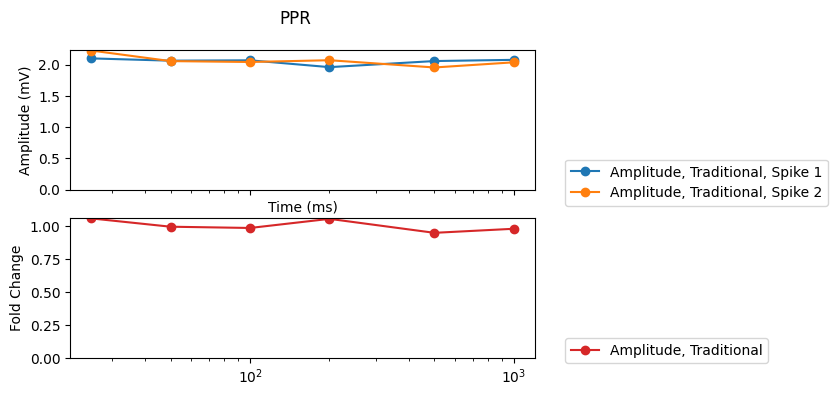

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (2) (20 uA increments)/, Post-IO
PEAK PROMINENCE IS 0.0
idx_low is empty! Using max value before spike
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

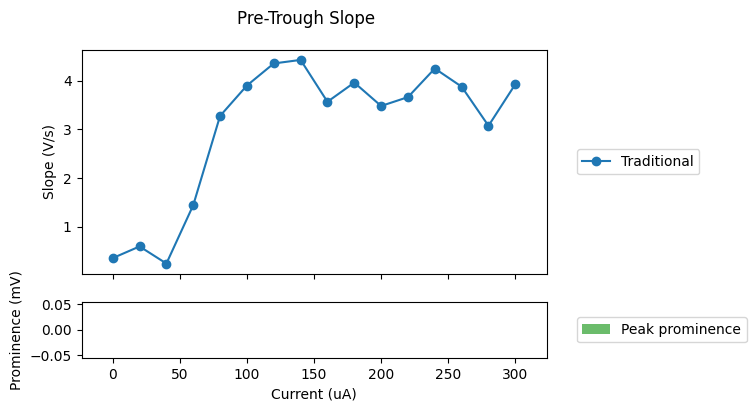

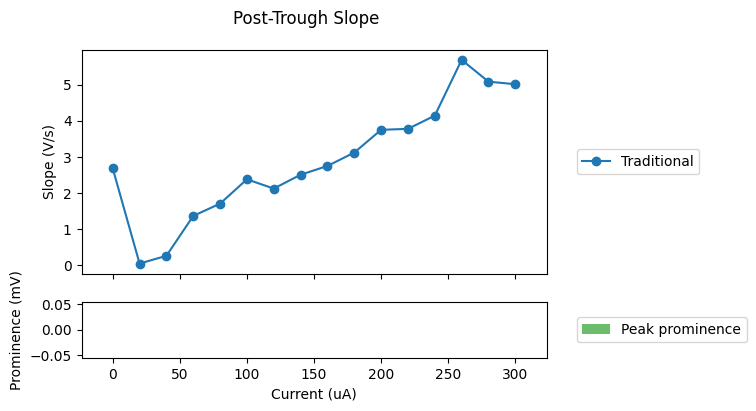

..Processing /mnt/isilon/marsh_single_unit/FieldPotentialAnalysis/abfs/2024_07_23 (2) (20 uA increments)/, Post-PPR
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.02355349063873291
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0
PEAK PROMINENCE IS 0.0


/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  prominence = peak_prominences(-V, [idx_peak])[0][0]
/tmp/ipykernel_966113/1789259237.py:141: PeakPropertyWarning: some peaks have a prominence of 0
  pr

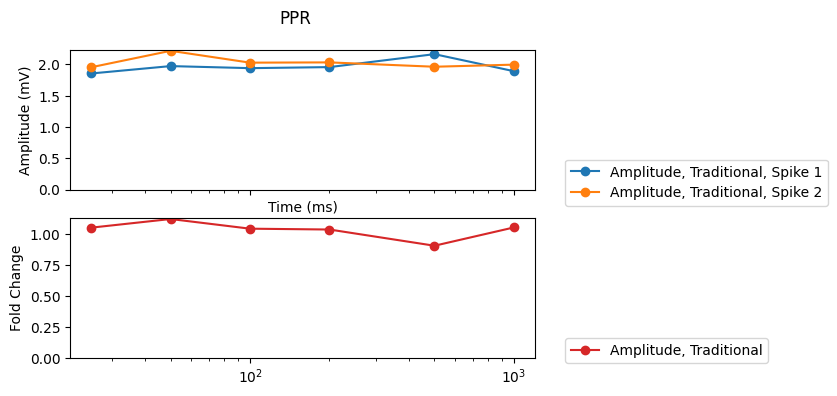

In [224]:
# Iterate through dataframe
recdf.drop((recdf[recdf['Day'] == "2024_06_25"]).index, inplace=True)
# recdf.drop((recdf[recdf['Day'] != "2024_07_23 (1)"]).index, inplace=True) # ASDFASDF
aggregate_io = np.zeros((recdf['Day'].nunique(), len(protocol_names) // 2, 16, len(spike_feature_names), len(spike_paramfunction_names))) # Hardcoded 16 samples per protocol
aggregate_ppr = np.zeros((recdf['Day'].nunique(), len(protocol_names) // 2, len(PPR_times), 2, len(spike_feature_names), len(spike_paramfunction_names))) # Hardcoded 16 samples per protocol
uniquefiles = recdf['Day'].unique()
uniquefiles.sort()
uniquefiles = uniquefiles.tolist()

for idx, row in recdf.iterrows():
    abf_file_fullname = [x for x in abf_subfolder_path_list if row['Day'] in x][0]
    
    print('='*50)
    print(f"..Processing {abf_file_fullname}, {row['Protocol']}")
    
    abf_file_list = glob.glob(f'{abf_file_fullname}/*.abf')
    abf_file_list.sort()
    
    abf_file_sublist, is_io = extract_IO_PPR_files(abf_file_list, row)
    # print(abf_file_sublist)
    
    # Process if IO curve acquisition
    if is_io:
        current_increment = int(re.sub('\D', '', row['Current Increment']))
        all_values = np.zeros((0, len(spike_feature_names), len(spike_paramfunction_names)))
        
        for abf_path in abf_file_sublist:
            
            V, t, f_s = extract_Vt(abf_path, mean=True)
            io_vals = calculate_risedecay(V, t, f_s, plot_traces=False, remove_low_prominence=False)
            
            io_vals = np.expand_dims(np.array(io_vals), axis=0)
            all_values = np.concatenate((all_values, io_vals), axis=0)
            
        for i, feature in enumerate(spike_feature_names):
            if i == len(spike_feature_names) - 1:
                continue
            if i <= 1: # Rise/Decay slope
                plot_risedecay_slopes(all_values[:, i, :] / 1000, feature, "Slope (V/s)", current_increment, all_values[:, 3, 1])
            elif i == 2:
                continue
                plot_risedecay_slopes(all_values[:, i, :], feature, "Amplitude (mV)", current_increment, all_values[:, 3, 1])

        aggregate_io[uniquefiles.index(row['Day']), protocol_names.index(row['Protocol']) // 2, :, :, :] = all_values.copy()
    else: # Process as PPR
        all_values = np.zeros((0, 2, len(spike_feature_names), len(spike_paramfunction_names)))
        for abf_path in abf_file_sublist:
                
            V, t, f_s = extract_Vt(abf_path, mean=True)
            ppr_vals = calculate_risedecay_PPR(V, t, f_s, plot_traces=False, remove_low_prominence=False)
            
            ppr_vals = np.expand_dims(np.array(ppr_vals), axis=0)
            all_values = np.concatenate((all_values, ppr_vals), axis=0)
        
        plot_PPR(all_values, "PPR", PPR_times)
        aggregate_ppr[uniquefiles.index(row['Day']), protocol_names.index(row['Protocol']) // 2, :, :, :, :] = all_values

# print(aggregate_io)
# print(aggregate_ppr)


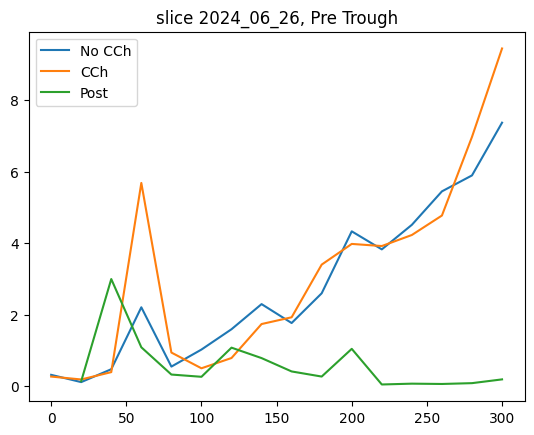

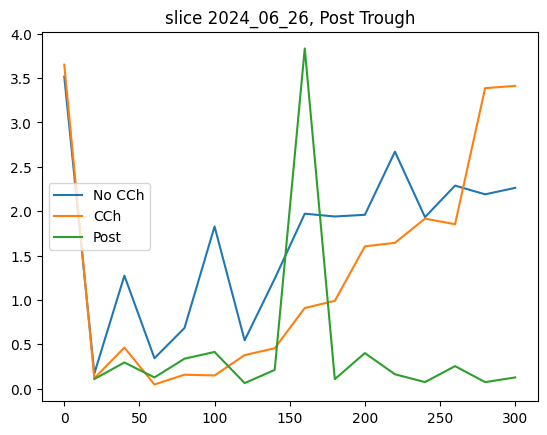

In [225]:
n_slice = 0
treats = ['No CCh', 'CCh', 'Post']
for i in range(3):
    plt.plot(np.arange(0, 16*20, 20), aggregate_io[n_slice, i, :, 0, 1] / -1000, label=treats[i])
    plt.title(f"slice {uniquefiles[n_slice]}, Pre Trough")
plt.legend()
plt.show()
for i in range(3):
    plt.plot(np.arange(0, 16*20, 20), aggregate_io[n_slice, i, :, 1, 1] / 1000, label=treats[i])
    plt.title(f"slice {uniquefiles[n_slice]}, Post Trough")
plt.legend()
plt.show()





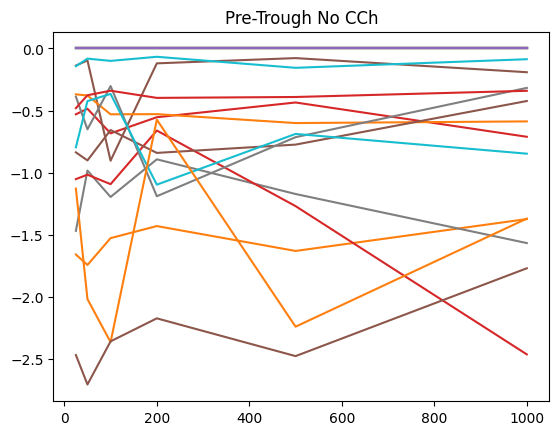

In [226]:
for i in range(13):
    plt.plot([1000, 500, 200, 100, 50, 25], aggregate_ppr[i, 0, :, 0, 1] / -1000)
    plt.title("Pre-Trough No CCh")
plt.show()
